In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import normalize

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import MAPE, MAE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

#---API related
import os 
from math import sqrt 
import yfinance as yf
from datetime import date, timedelta, datetime
from stock_prediction.data_prep_api import Data_Prep_Api
from stock_prediction.features_exo_api import exo_selection_api

# Load data to train

## Data exploration

In [2]:
def load_preproc_data(company):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class without Volatility Annual feature=> use period
    prep_class = Data_Prep(company, 20)
    
    df = prep_class.data_prep()
    
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                            Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection(df, sp500=True, gold=True, eurusd=True, nasdaq=True, crude=True, vix=True)

    df = df.sort_values('Date')  
    df = df.set_index('Date')
    
    idx = df.columns[0][7:]
    
    return df, idx

In [115]:
len_=20

In [116]:
def load_data_api(company, start_date='2020-01-03', end_date='2020-12-31', len_=len_):

    prep_class = Data_Prep_Api(company, len_)
    df = prep_class.data_prep_api() # (max=True)
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection_api(df, ["sp500","gold", "eurusd", "nasdaq", "crude", "vix"]) # ,max=True)

    df = df.sort_values('Date')

    start_date_delta = str((datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=len_)).date()) # replace with extracted len_ from loaded model
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]

    df = df.set_index('Date')

    idx = df.columns[0][7:]

    return df, idx

In [3]:
data, idx = load_preproc_data('vinci')

In [6]:
data.shape

(1259, 15)

## Data preprocessing TS oriented

In [117]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [118]:
def shift_sequences(df, idx, length=len_, horizon=1):
    
    """This function is able to get as many subsequences for X and a corresponding target y
    Nas possible, taking in account lenght of sequence and horizon."""
    
    last_possible = df.shape[0] - length - horizon
    X=[]
    y=[]
    for start in range(last_possible):
        X.append(df[start: start+length].values)
        y.append(df.iloc[start+length+horizon][f'Return_{idx}'])
    
    # random permutation of the sequences to train
    perm = np.random.permutation(last_possible)
    X = np.array(X)[perm, :, :]
    y = np.array(y)[perm]
    return X, y

In [119]:
def shift_sequences_pred(df, idx, length=len_, horizon=1):
    
    """This function is able to get as many subsequences for X and a corresponding target y
    Nas possible, taking in account lenght of sequence and horizon."""
    
    last_possible = df.shape[0] - length - horizon
    X=[]
    y=[]
    for start in range(last_possible):
        X.append(df[start: start+length].values)
        y.append(df.iloc[start+length+horizon][f'Return_{idx}'])

    X = np.array(X)
    y = np.array(y)
    return X, y

## Model RNN

In [120]:
company_dict = {
    'asml' : 'ASML.AS',
    'lvmh': 'MC.PA',
    'sap' : 'SAP.DE',
    'linde' : 'LIN',
    'siemens' : 'SIE.DE',
    'total' : 'FP.PA',
    'sanofi' : 'SAN.PA',
    'allianz' : 'ALV.DE', 
    'schneider' : 'SU.PA',
    'iberdrola' : 'IBE.MC',
    'enel' : 'ENEL.MI',
    'air-liquide' : 'AI.PA',
    'basf' : 'BAS.DE',
    'bayer' : 'BAYN.DE',
    'adidas' : 'ADS.DE',
    'airbus' : 'AIR.PA',
    'adyen' : 'ADYEN.AS',
    'deutsche-telecom' : 'DTE.DE',
    'daimler' : 'DAI.DE',
    'bnp' : 'BNP.PA',
    'anheuser-busch' : 'ABI.BR',
    'vinci' : 'DG.PA',
    'banco-santander' : 'SAN.MC',
    'philips' : 'PHIA.AS',
    'kering' : 'KER.PA',
    'deutsche-post' : 'DPW.DE',
    'axa' : 'CS.PA',
    'safran' : 'SAF.PA',
    'danone'  : 'BN.PA',
    'essilor' : 'EL.PA',
    'intensa' : 'ISP.MI',
    'munchener' : 'MUV2.DE',
    'pernod' : 'RI.PA',
    'vonovia' : 'VNA.DE',
    'vw' : 'VOW3.DE',
    'ing' : 'INGA.AS',
    'crh' : 'CRG.IR',
    'industria-diseno' : 'ITX.MC',
    'kone' : 'KNEBV.HE',
    'deutsche-borse' : 'DB1.DE',
    'ahold' : 'AHOG.DE',
    'flutter' : 'FLTR.IR',
    'amadeus' : 'AMS.MC',
    'engie' : 'ENGI.PA',
    'bmw' : 'BMW.DE',
    'vivendi' : 'VIV.PA',
    'eni' : 'ENI.MI',
    'nokia' : 'NOKIA.HE'
}

In [157]:
#---Pipeline
def train_model(df,
                idx,
                train_threshold=0.6,
                val_threshold=0.8,
                nb_sequences=50,
                len_=len_,
                l_rate=0.01,
                momentum=0.9,
                loss='MAE',
                metric=MAE,
                patience=50,
                batch_size=32,
                horizon=1,
                plot_history=False,
                verbose=2):
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes a model with (Normalization), LSTM/GRU/Conv1D and 2 fully connected layers.
    Returns: X_train, y_train, X_test, y_test, model"""
    
#     regul = 0

    if not isinstance(df, list):
        df = [df]

    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    for nb_df, df_loc in enumerate(df):
        idx_loc = idx[nb_df]
        
        #---Split train, test, val sets
        df_train, df_val, df_test = train_test_val_split(df_loc,
                                                         train_threshold=train_threshold,
                                                         val_threshold=val_threshold)
        #---Get train, test, val X and y sequences
    #     X_train_loc, y_train_loc = get_X_y(df_train, idx_loc, length=len_, number_of_sequences=nb_sequences)
    #     X_val_loc, y_val_loc = get_X_y(df_val, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)
    #     X_test_loc, y_test_loc = get_X_y(df_test, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)

        X_train_loc, y_train_loc = shift_sequences(df_train, idx_loc, length=len_)
        X_val_loc, y_val_loc = shift_sequences(df_val, idx_loc, length=len_)
        X_test_loc, y_test_loc = shift_sequences(df_test, idx_loc, length=len_)
        
        X_train.append(X_train_loc)
        y_train.append(y_train_loc)
        
        X_val.append(X_val_loc)
        y_val.append(y_val_loc)
        
        X_test.append(X_test_loc)
        y_test.append(y_test_loc)
    
    # Data concatenation
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    # Data shuffle (random, different for train / val / test)
    perm = np.random.permutation(len(X_train))
    X_train, y_train = X_train[perm], y_train[perm]
    perm = np.random.permutation(len(X_val))
    X_val, y_val = X_val[perm], y_val[perm]
    perm = np.random.permutation(len(X_test))
    X_test, y_test = X_test[perm], y_test[perm]
    
#     print(np.any(np.isnan(X_train)))
#     print(np.any(np.isnan(X_val)))
#     print(np.any(np.isnan(X_test)))

    normalizer = Normalization()
    normalizer.adapt(X_train)  # , axis=-1, order=1 as minmax

    #---Initialize the model
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(len_, X_train.shape[-1])))
    model.add(normalizer)
    #     model.add(layers.BatchNormalization(input_shape=(len_,X_train.shape[-1])))
    
#     model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(30, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(20, return_sequences=False, activation='tanh'))

    model.add(layers.Conv1D(128, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(32, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='linear'))
    
#     model.add(layers.LSTM(50, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(30, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(20, return_sequences=False, activation='tanh', kernel_regularizer=regularizers.l2(regul)))

#     model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(regul)))

    model.compile(
        loss=loss,
        optimizer=Adam(l_rate),  # RMSprop(learning_rate=l_rate, momentum=momentum), 
        metrics=[metric])
    
    print(X_train.shape)
    print(model.summary())

    es = EarlyStopping(monitor='val_loss',
                       patience=patience,
                       restore_best_weights=True)
    
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                           patience=round(patience/2))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es, lr],
                        verbose=verbose)

    if plot_history:

        plot_loss(history, patience)

    return X_train, y_train, X_val, y_val, X_test, y_test, model

In [72]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.semilogy(history.history['loss']) # plot train loss
    plt.semilogy(history.history['val_loss']) # plot val loss
    plt.title('Loss & Metric')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
#     plt.plot(history.history['mean_absolute_percentage_error'])
#     plt.plot(history.history['val_mean_absolute_percentage_error'])
#     plt.title('MAPE')
#     plt.ylabel('Mean Absolute Percentage Error')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='best')
#     plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mae = history.history['val_mean_absolute_error'][stop_epoch]

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mae: {val_mae}")

## Load the data  and make some tests

In [123]:
#---load the data with selected features to train with
data = []
idx = []
for company in company_dict.keys():
    data_loc, idx_loc = load_data_api(company, start_date='2017-05-31', end_date='2019-10-04')
    data.append(data_loc)  # Pre-covid data
    idx.append(idx_loc)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

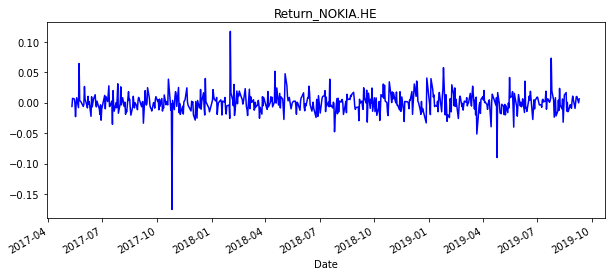

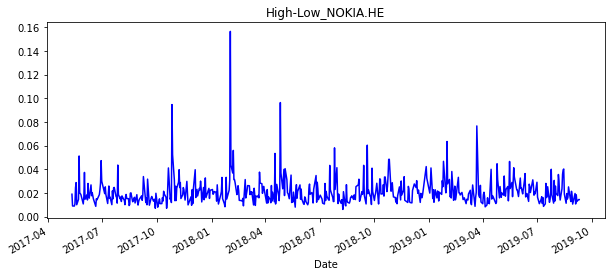

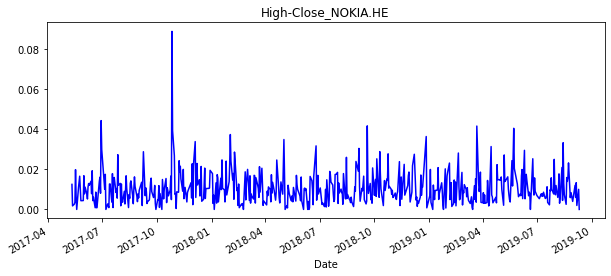

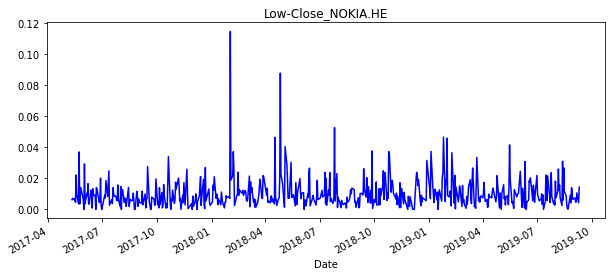

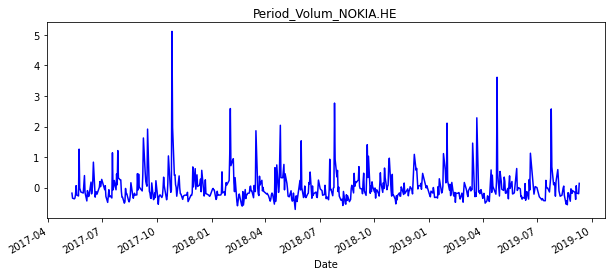

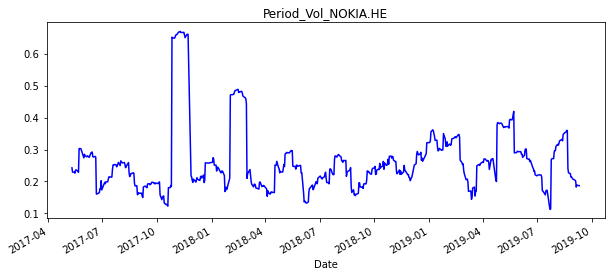

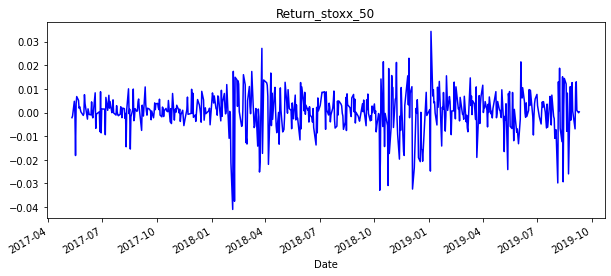

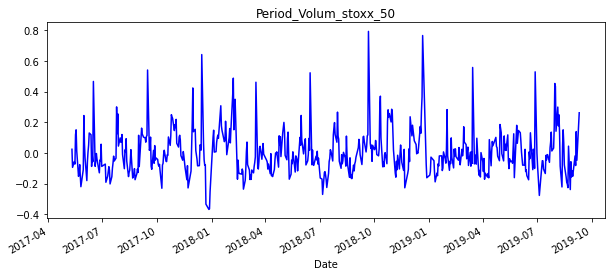

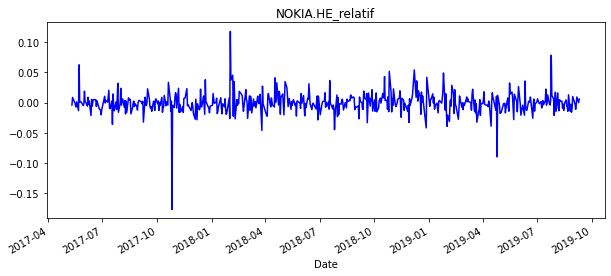

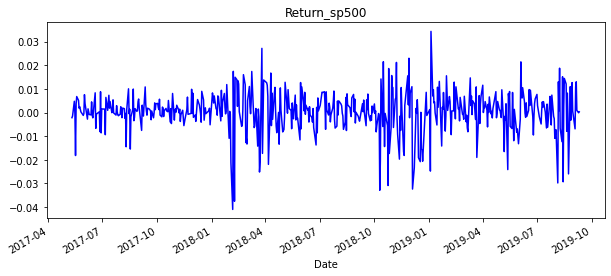

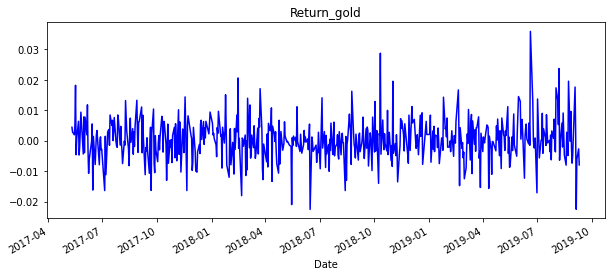

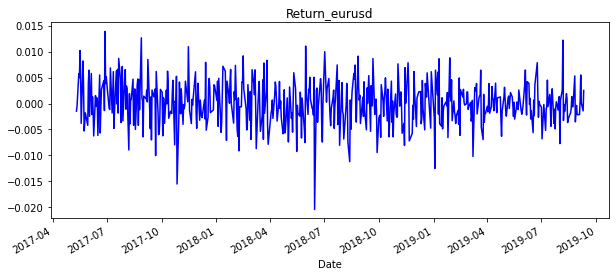

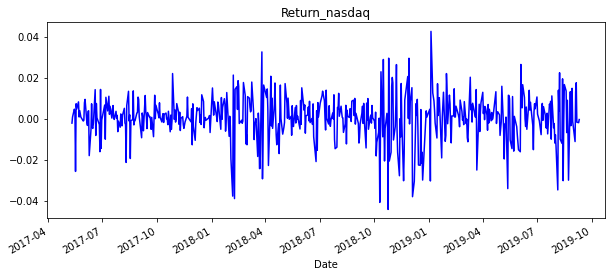

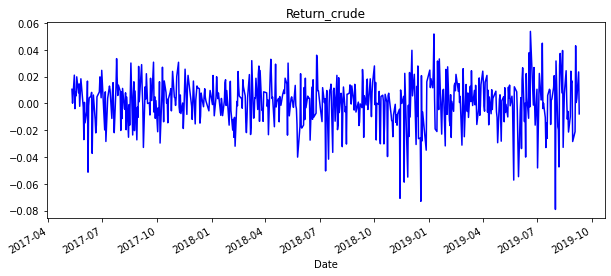

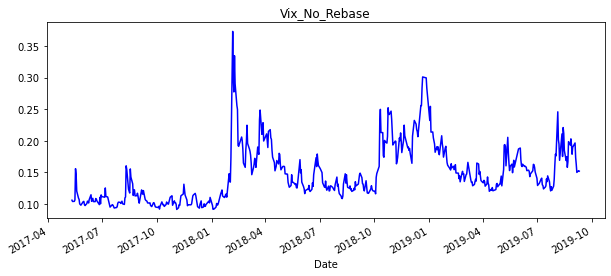

In [124]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data_loc.columns:
    color="green" if col == f"Return_{idx}" else "blue"
    data_loc[col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

(15192, 20, 15)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_13 (Normalizat (None, 20, 15)            31        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 128)           3968      
_________________________________________________________________
dropout_36 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 64)             16448     
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 4

Epoch 49/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 50/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 51/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 52/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 53/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 54/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 55/1000
238/238 - 2s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 56/1000
238/238 - 3s - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110


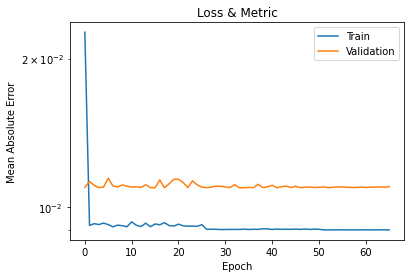

early stopping at 65 epoch.
val_mae: 0.010953182354569435


In [160]:
#---train the model
X_train, y_train, X_val, y_val, X_test, y_test, model = train_model(df=data,
                                                                    idx=idx,
                                                                    len_=20, 
                                                                    l_rate=0.01,
                                                                    batch_size=64,
                                                                    patience=50,
                                                                    loss='MAE',
                                                                    metric=MAE,
                                                                    plot_history=True, 
                                                                    verbose=2)

In [144]:
X_test.shape

(4428, 20, 15)

In [145]:
#---Prediction
res = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test, )

In [146]:
y_pred.shape

(4428, 1)

Prediction of stock return on J+1: [[0.00108952]
 [0.00108952]
 [0.00108952]
 ...
 [0.00108952]
 [0.00108952]
 [0.00108952]] with mae 0.010444248095154762


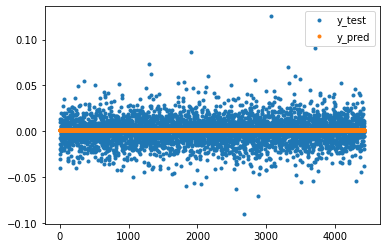

In [147]:
plt.plot(y_test, '.',  label='y_test')
plt.plot(y_pred, '.', label='y_pred') #'.'
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred} with mae {res[1]}")

In [130]:
#baseline
np.mean(np.abs(y_test))

0.010414708000840416

**Load API data to predict return for a given period**

In [139]:
#---load the data with selected features

prediction = {}

for company in ['airbus']: #company_dict.keys():
    data_to_predict_loc, idx__loc = load_data_api(company, start_date='2020-01-03', end_date = '2020-12-31')
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=len_)

    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


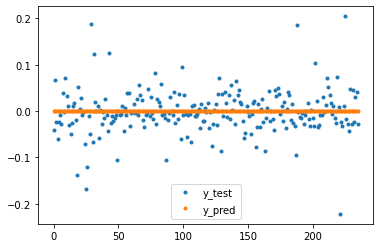

In [140]:
plt.plot(y_test_loc, '.', label='y_test')
plt.plot(prediction['airbus'], '.', label = 'y_pred')
plt.legend()

In [141]:
prediction

{'airbus': array([[0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],
        [0.00109069],


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


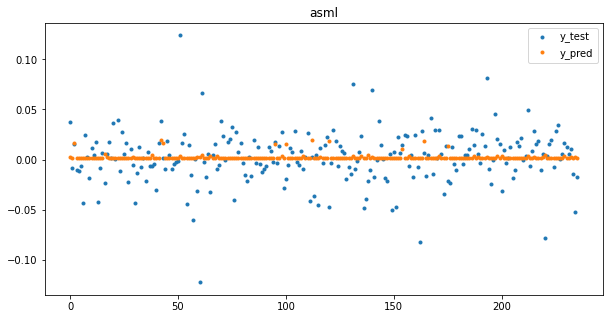

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


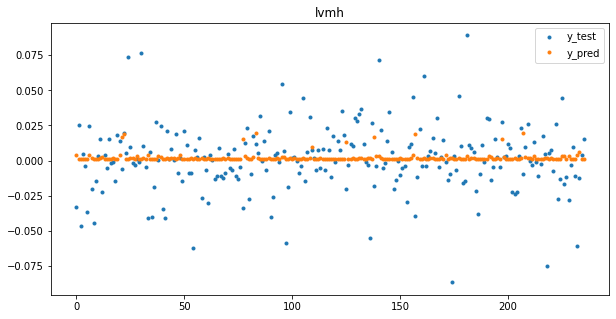

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


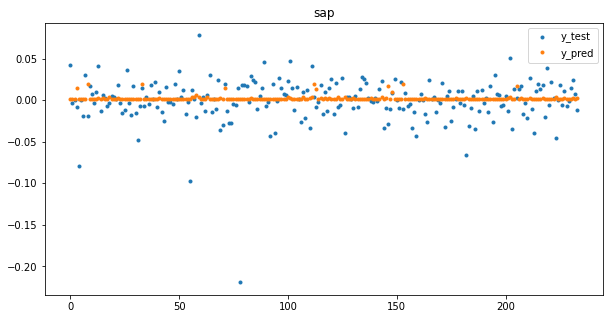

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 16)


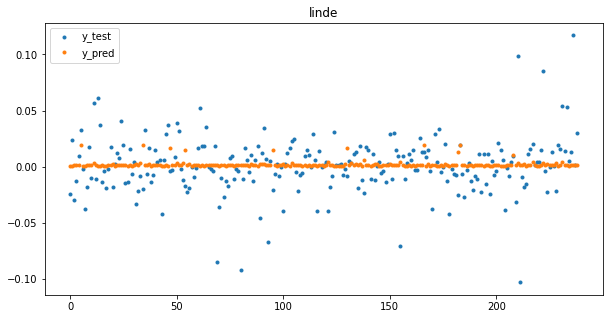

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


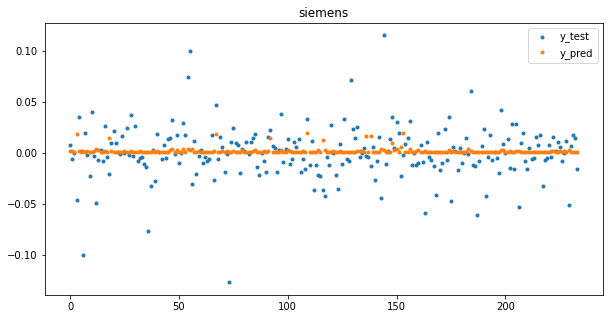

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


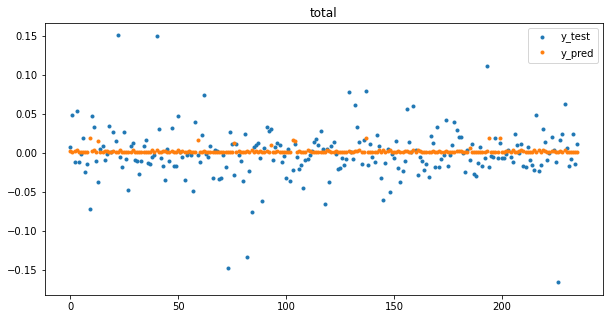

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


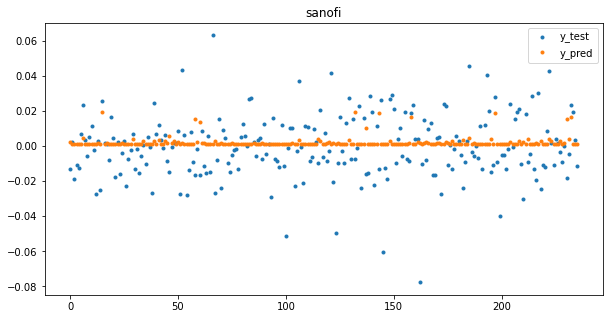

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


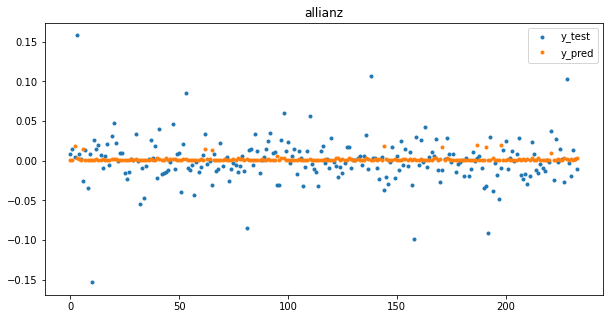

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


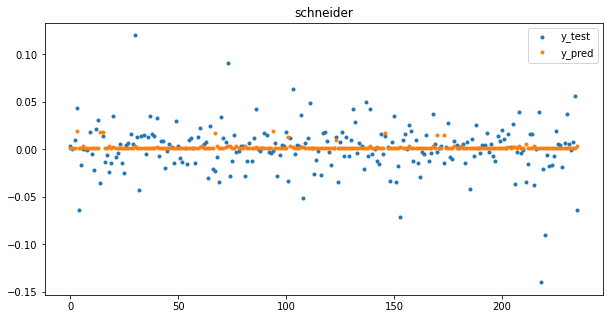

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


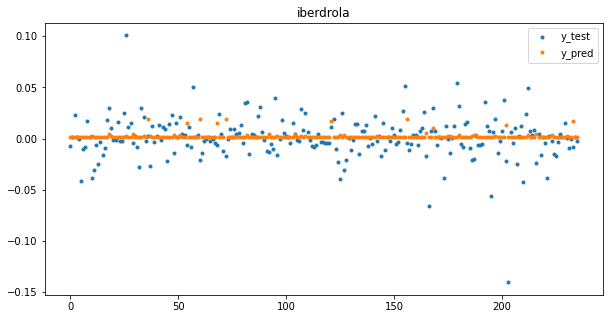

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


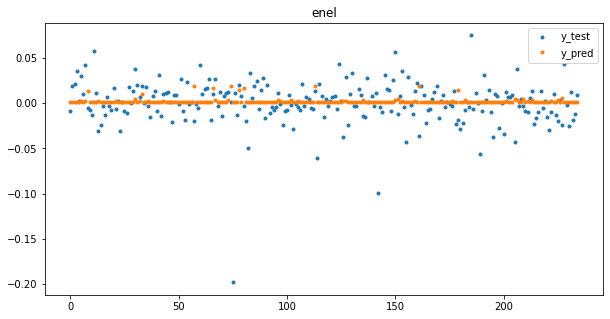

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


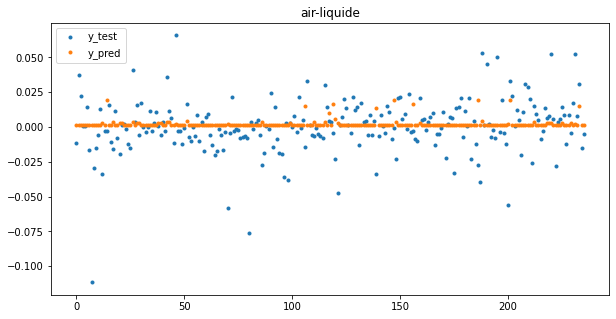

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


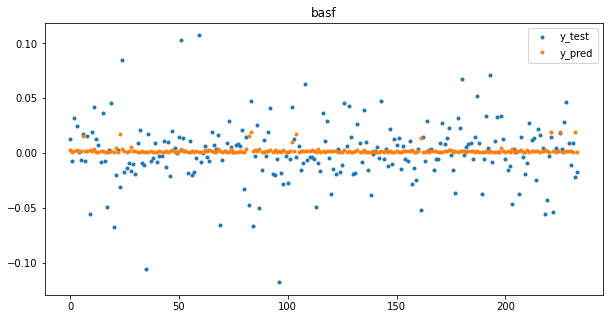

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


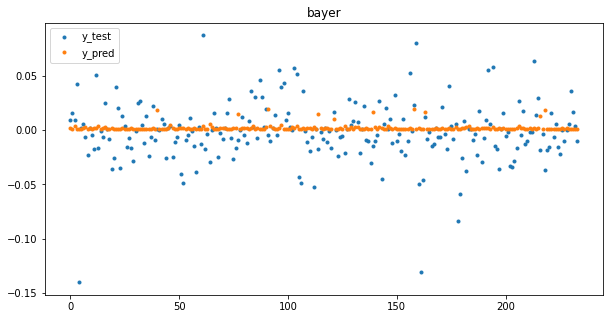

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


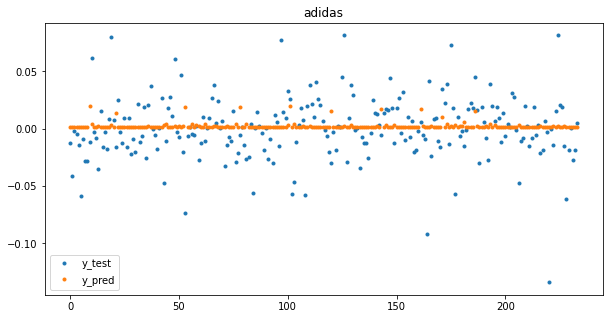

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


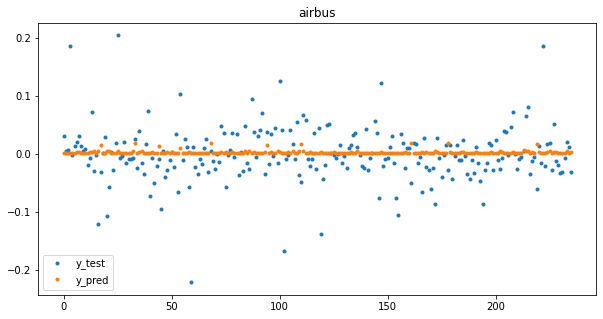

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


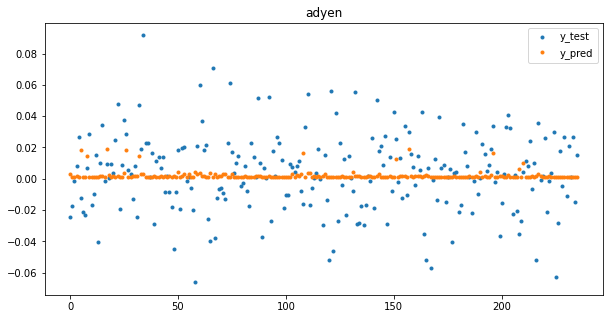

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


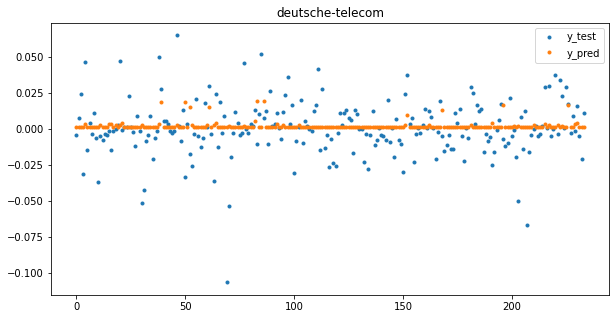

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


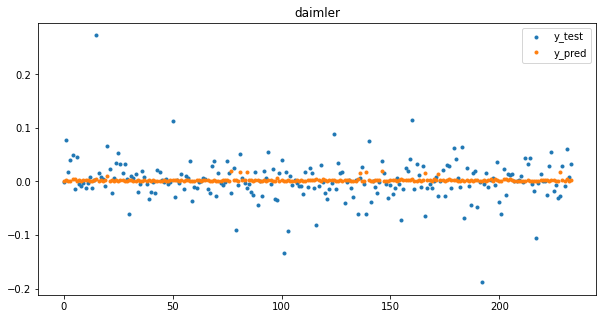

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


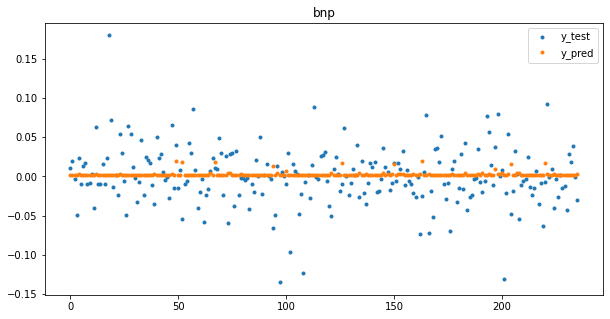

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


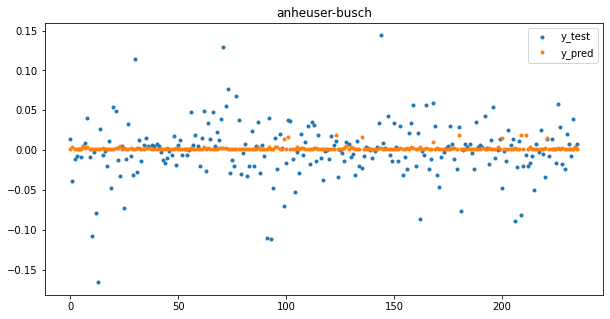

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


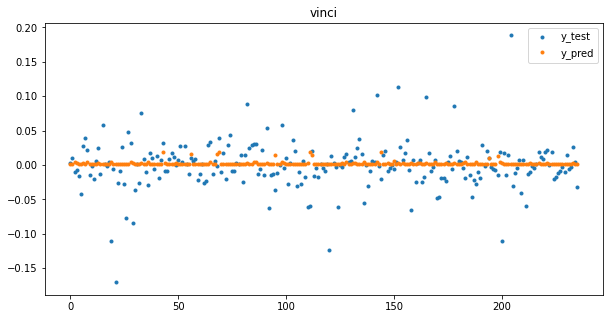

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


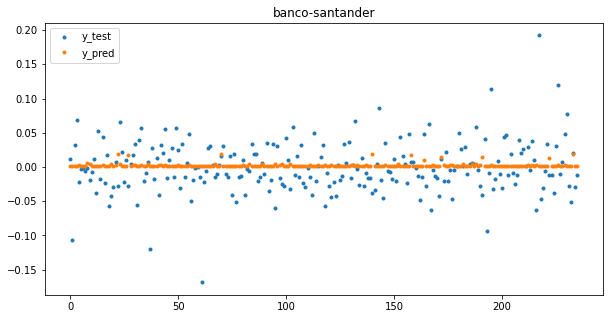

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


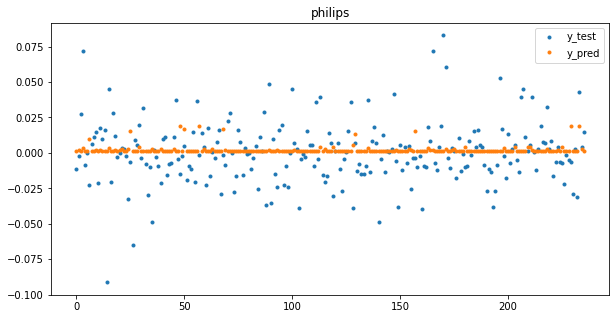

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


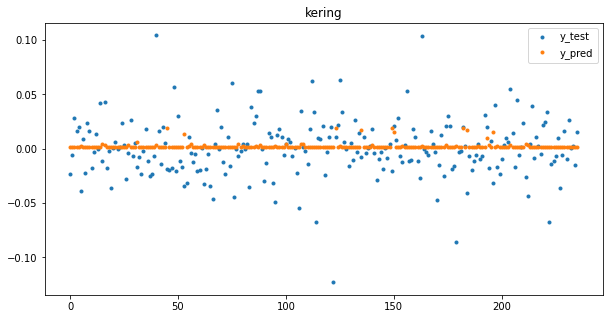

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


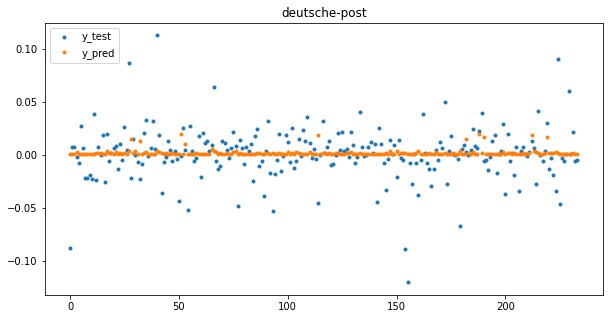

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


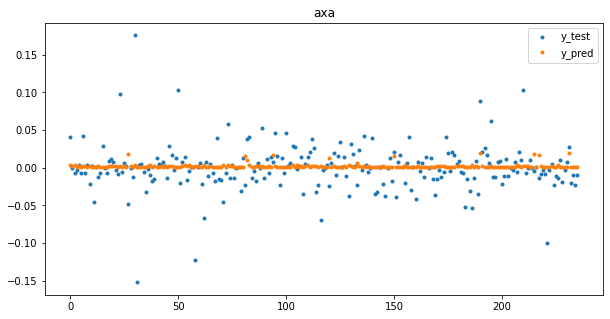

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


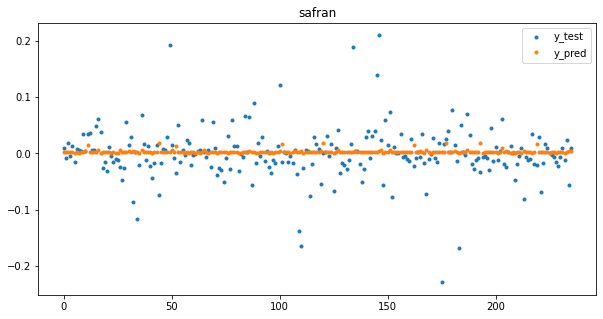

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


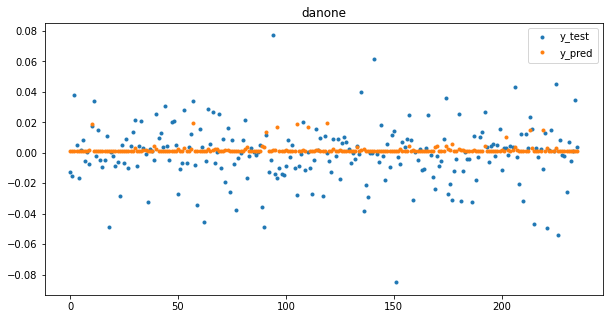

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


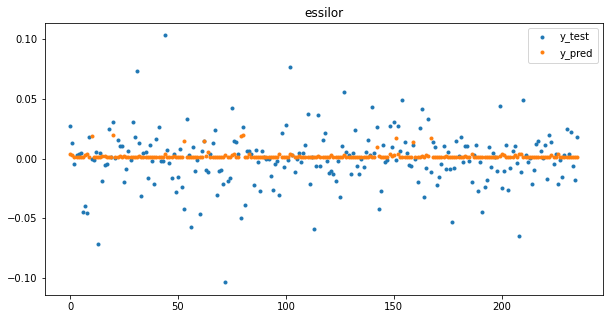

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


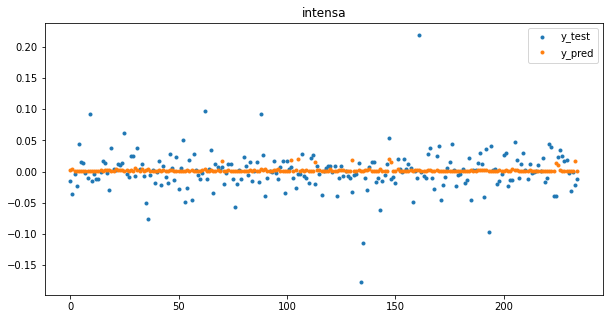

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


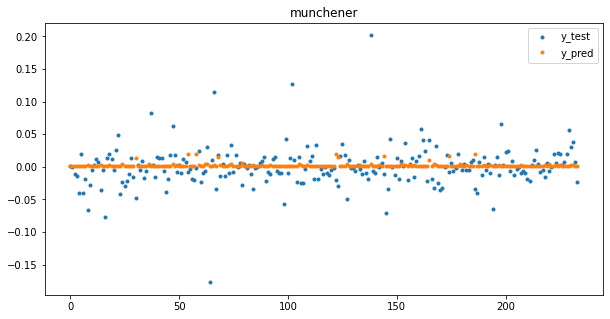

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


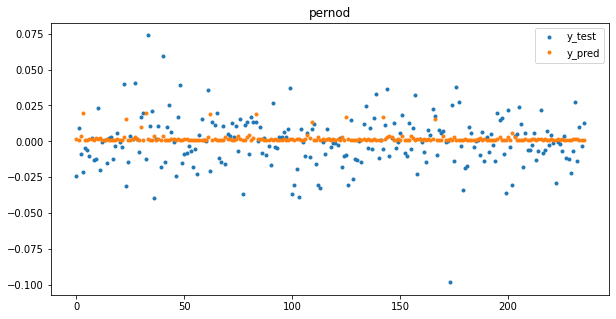

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


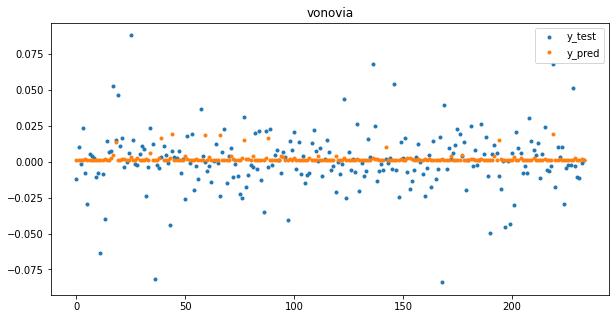

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


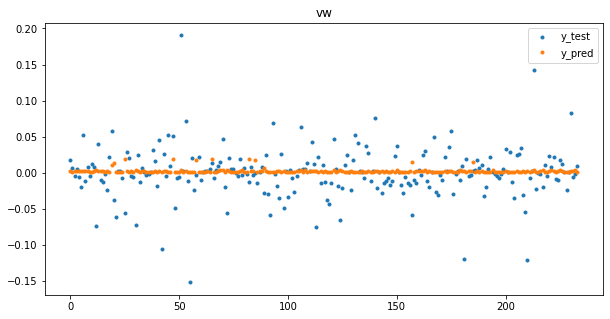

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


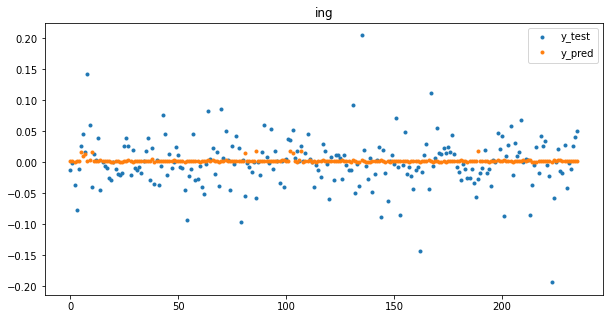

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


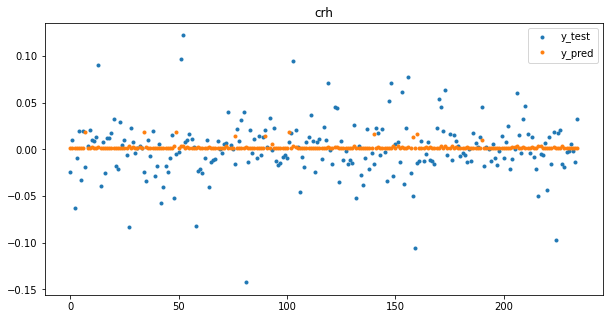

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


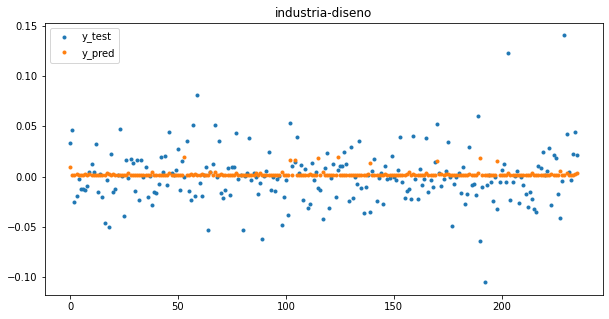

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


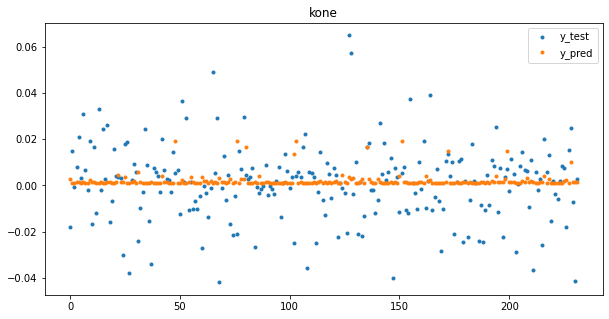

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


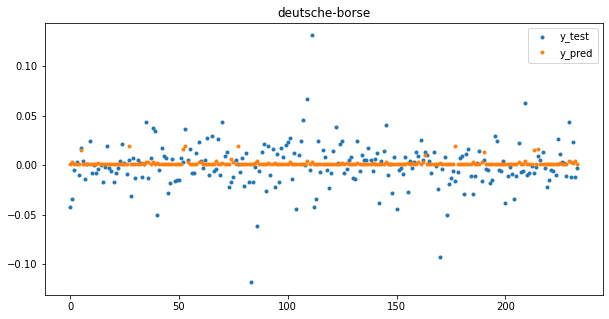

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


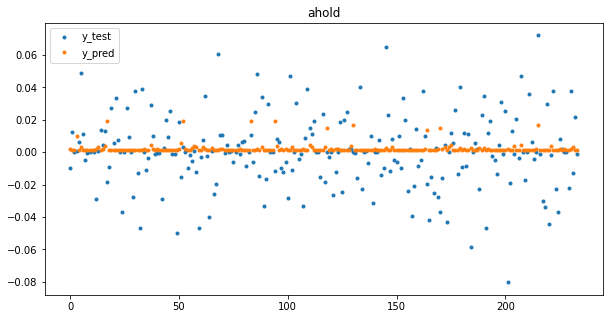

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


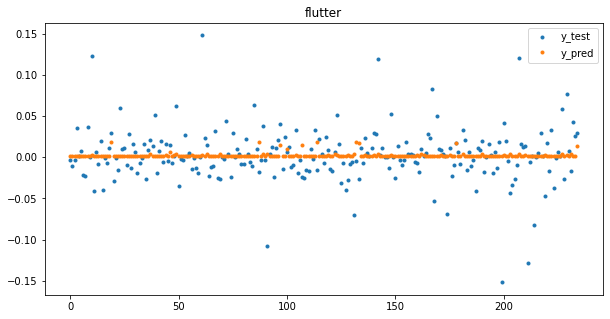

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


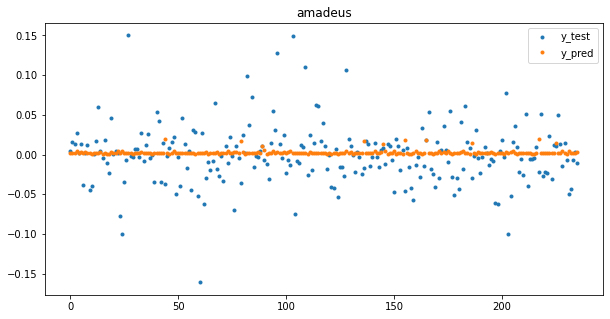

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


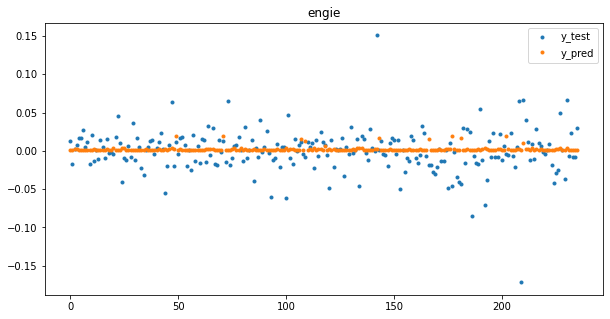

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


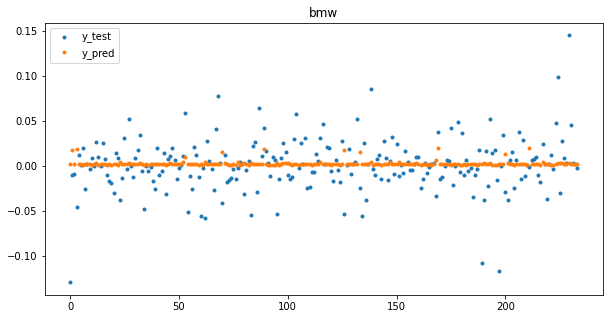

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


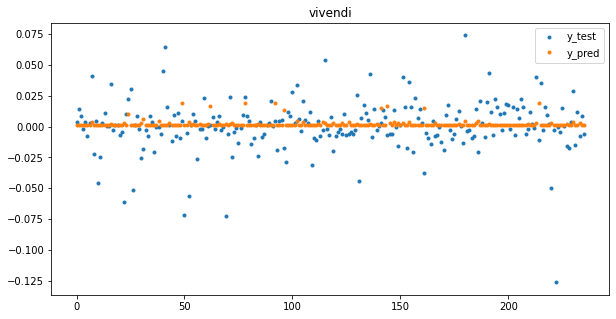

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


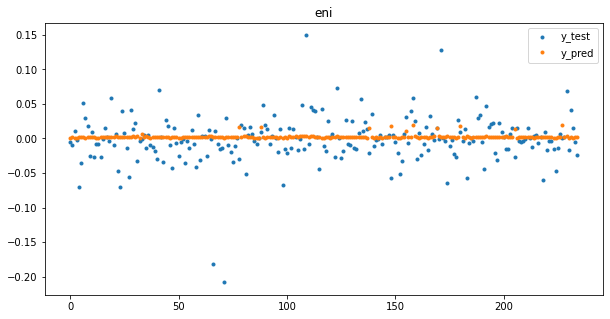

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


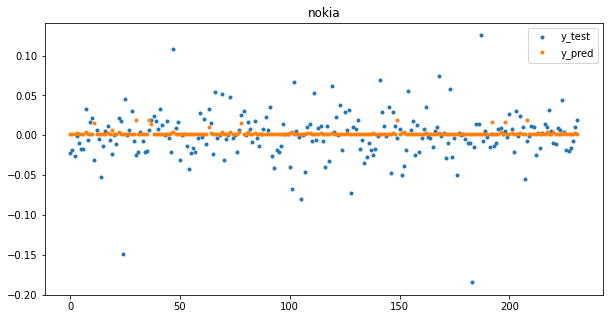

In [275]:
prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [272]:
prediction['nokia'].shape

(232, 1)

In [278]:
prediction['asml']

array([0.00254707, 0.00118564, 0.01674582, 0.00177993, 0.00136265,
       0.0017426 , 0.00143812, 0.00177993, 0.00148748, 0.00161699,
       0.00135458, 0.00144053, 0.0013033 , 0.00118564, 0.00128448,
       0.00130719, 0.00585582, 0.00205268, 0.00142653, 0.00123342,
       0.00118564, 0.00118564, 0.00118564, 0.00139154, 0.00118564,
       0.00118564, 0.00128156, 0.00119726, 0.00118564, 0.00254802,
       0.00118564, 0.00160312, 0.00155784, 0.00131595, 0.00156587,
       0.00118564, 0.00118564, 0.00170965, 0.00436538, 0.00127529,
       0.00118564, 0.00177542, 0.01902643, 0.01674582, 0.00135007,
       0.00136443, 0.00139154, 0.00163714, 0.0013033 , 0.00130484,
       0.00120208, 0.00339442, 0.00143812, 0.00144444, 0.00124477,
       0.00137879, 0.00139073, 0.00127455, 0.00136434, 0.00213675,
       0.00226539, 0.00436538, 0.00128819, 0.00149589, 0.00122197,
       0.00396709, 0.00167352, 0.00163714, 0.00326007, 0.00136434,
       0.0017053 , 0.00118564, 0.00159881, 0.00118564, 0.00158

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


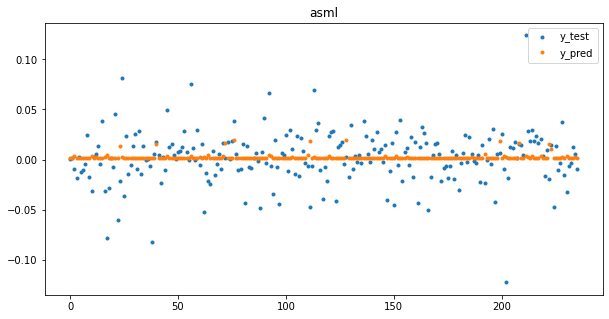

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


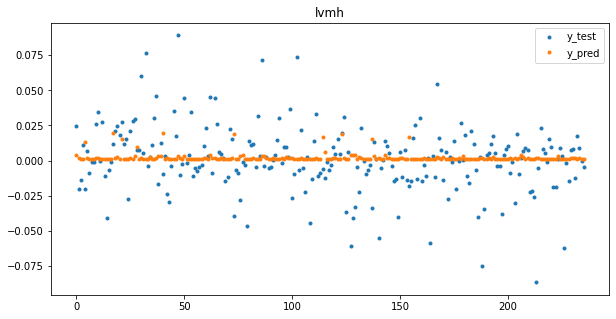

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


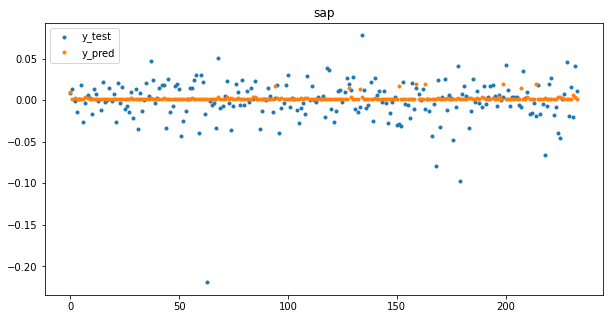

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 16)


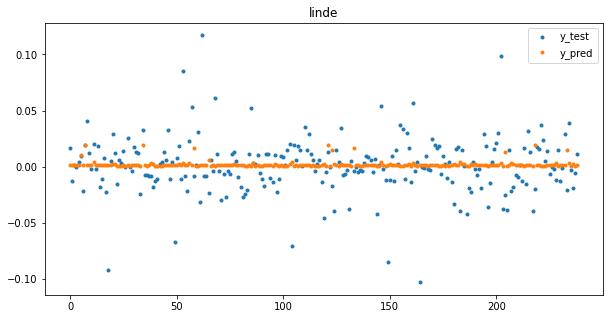

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


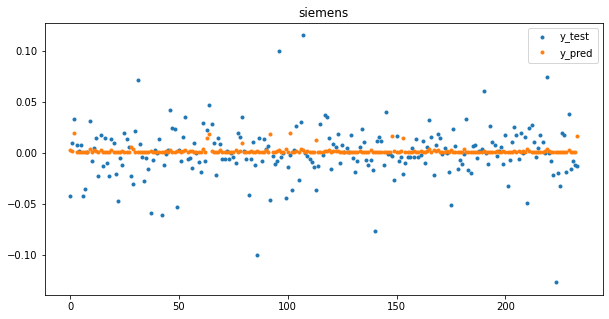

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


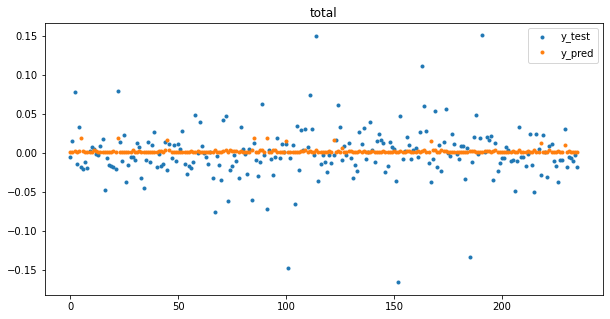

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


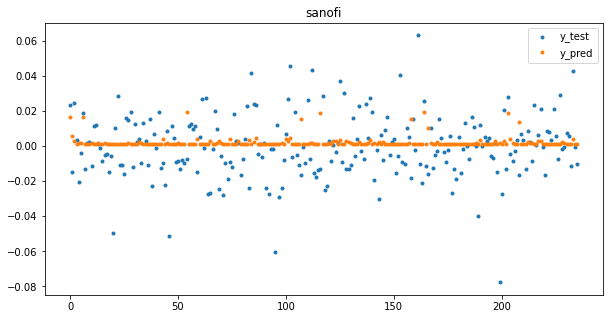

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


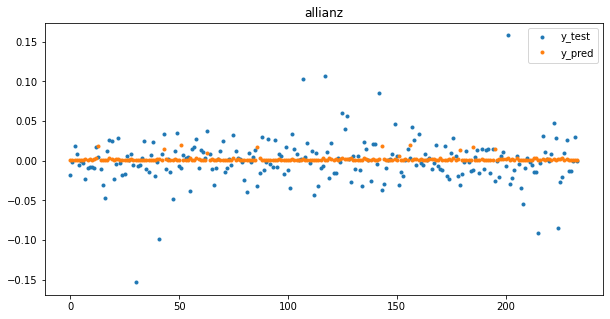

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


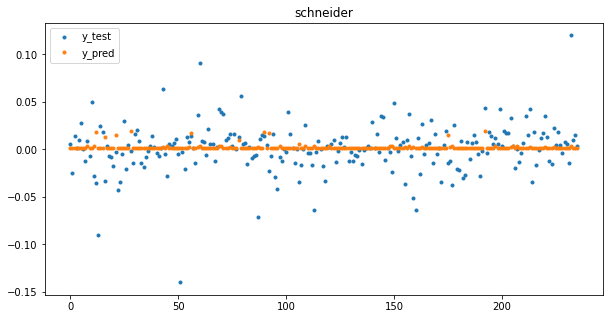

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


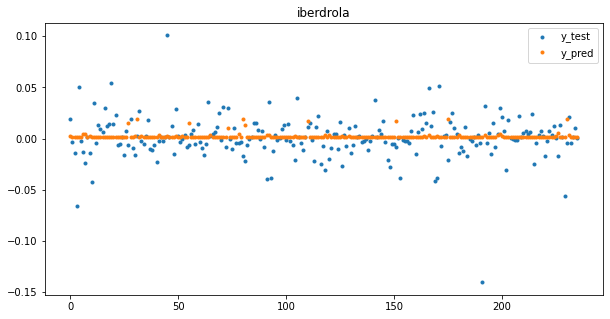

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


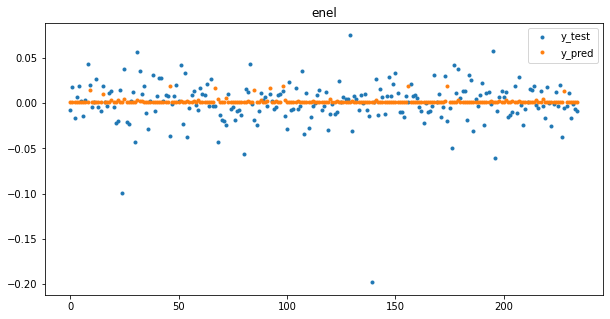

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


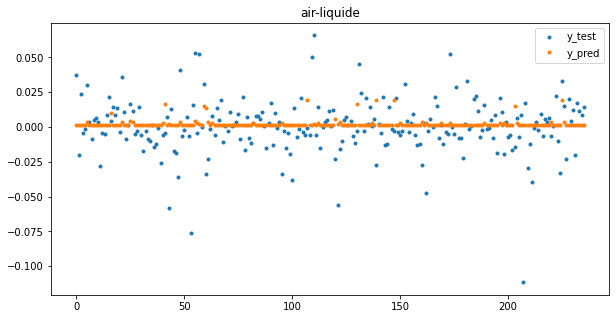

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


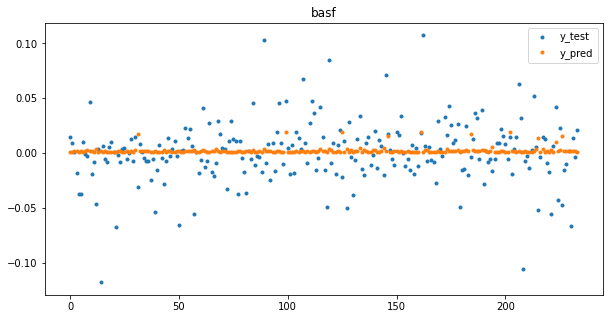

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


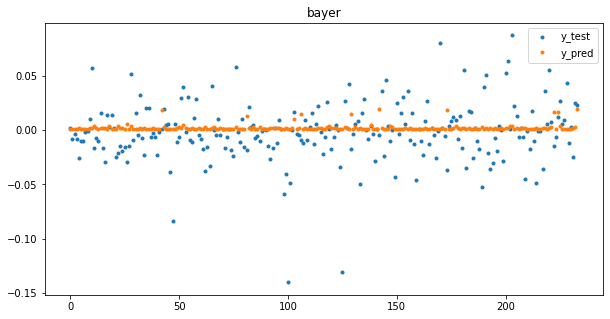

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


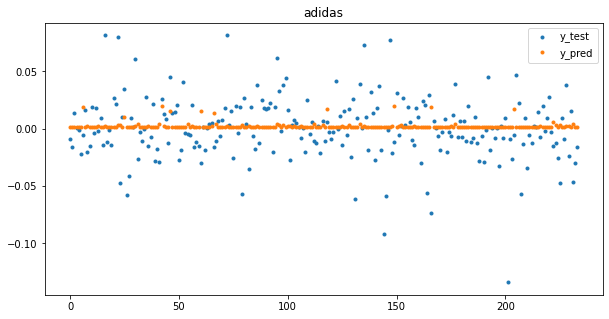

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


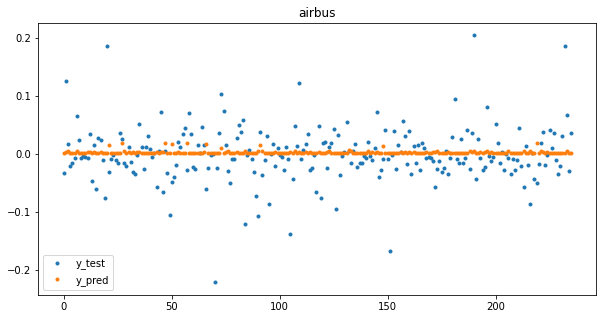

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


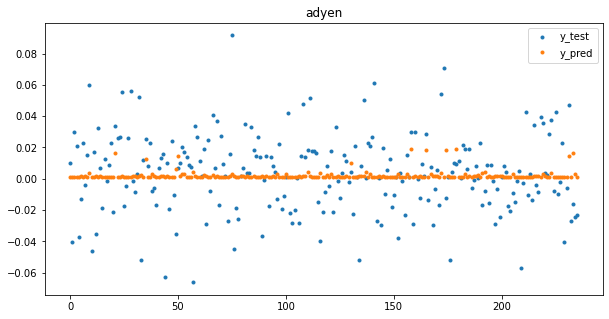

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


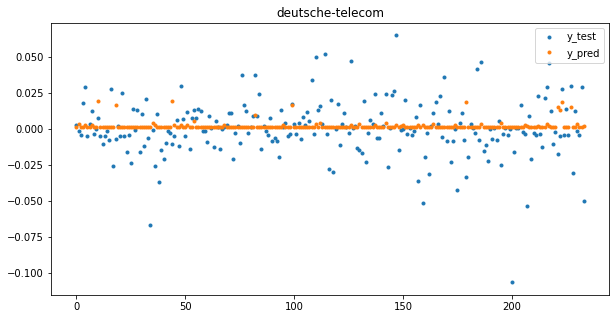

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


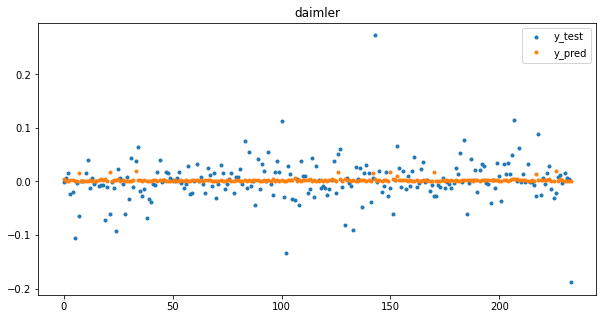

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


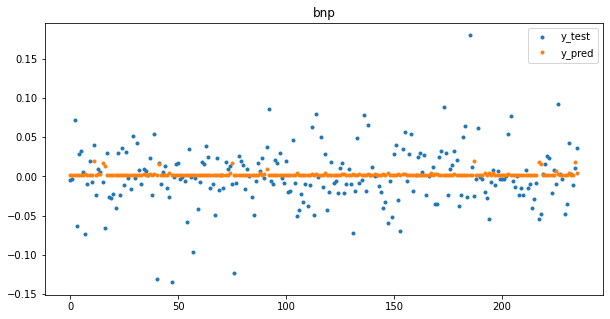

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


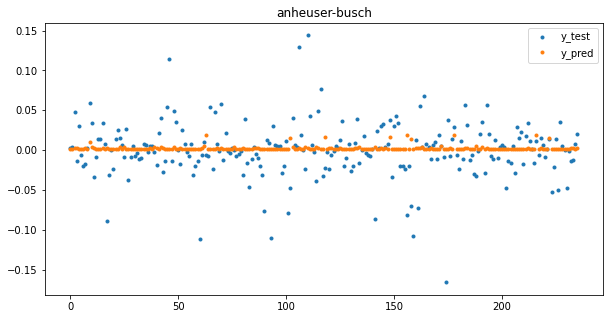

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


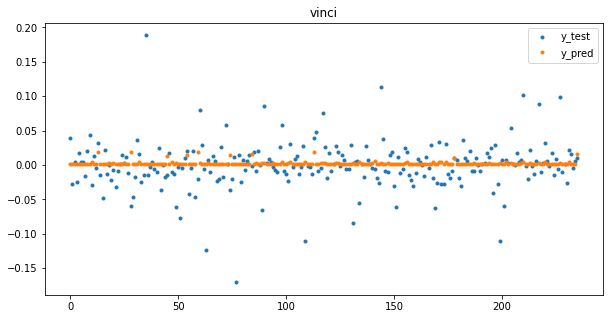

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


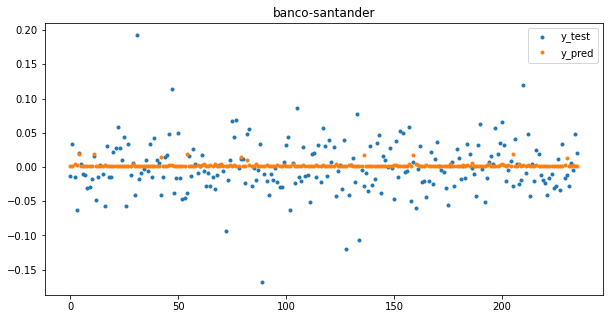

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


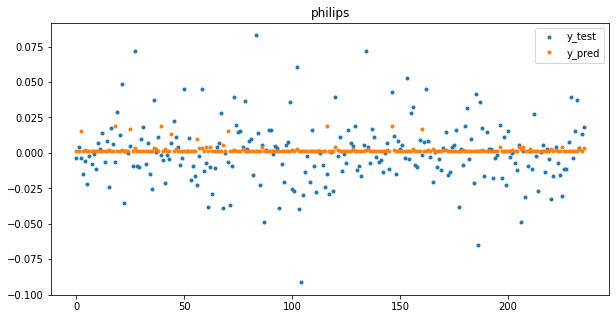

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


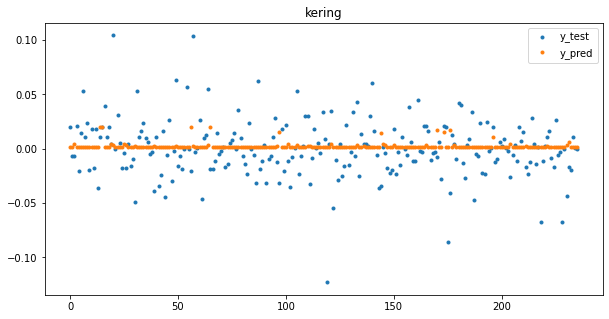

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


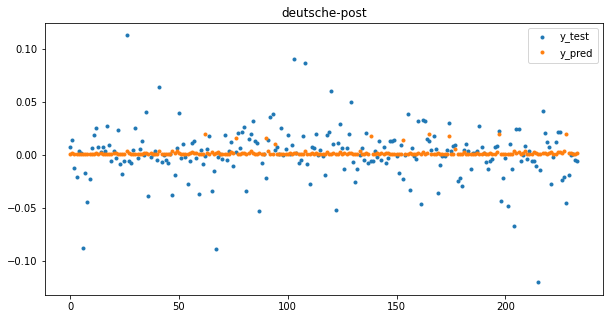

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


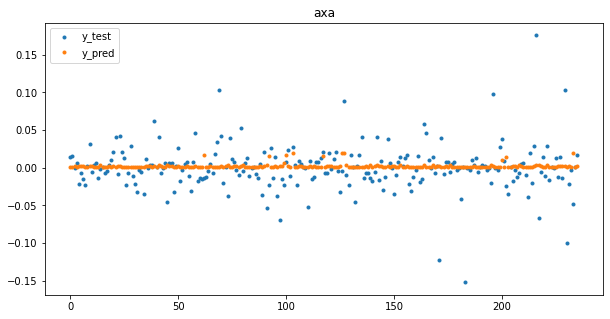

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


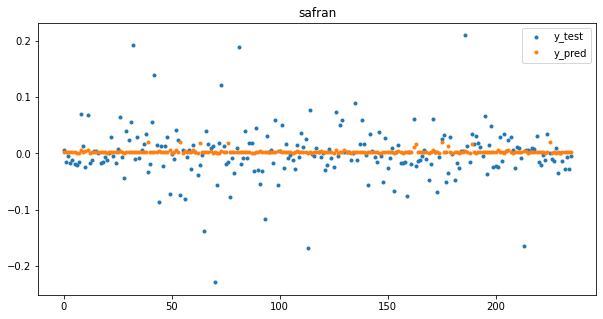

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


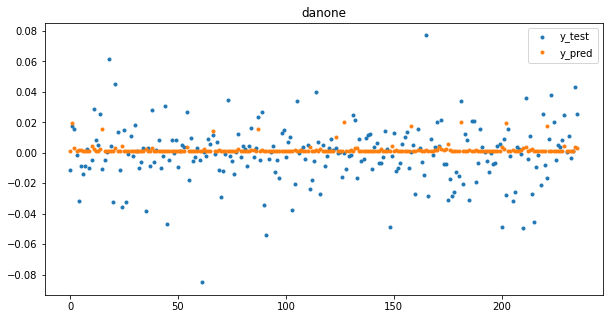

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


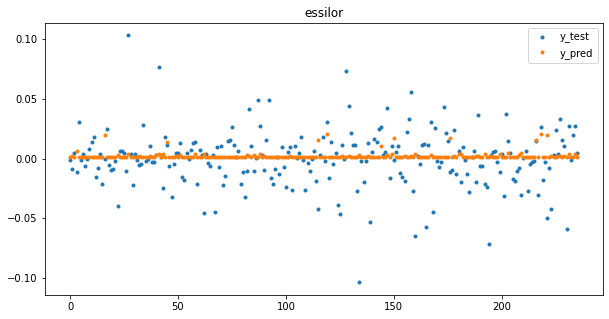

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


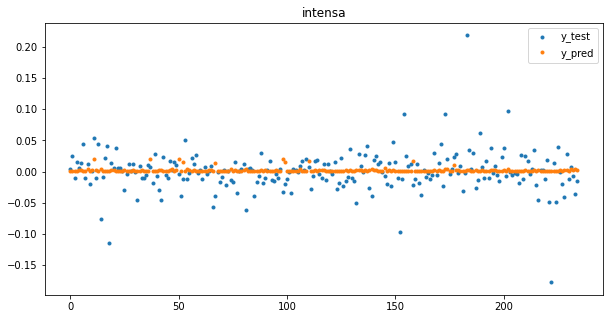

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


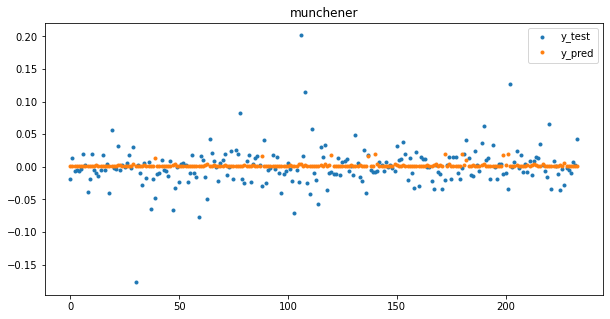

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


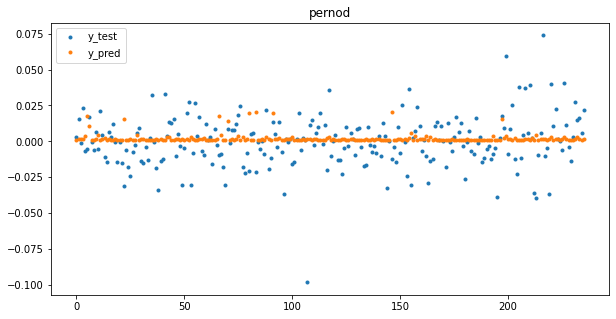

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


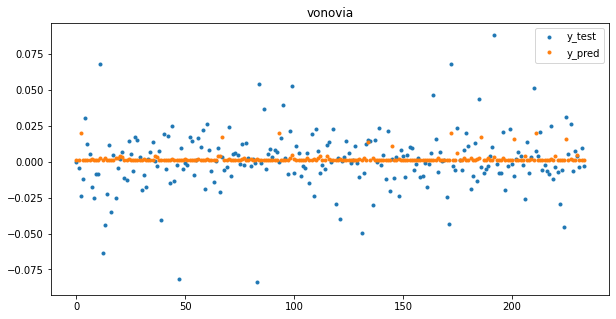

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


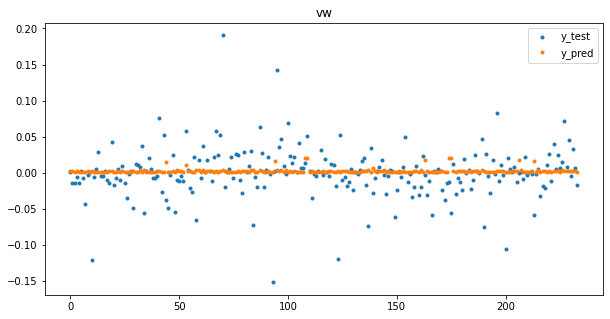

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


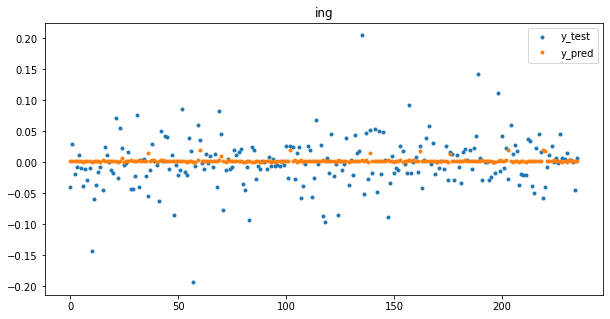

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


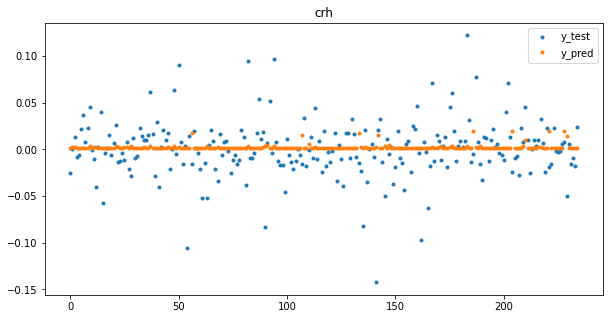

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


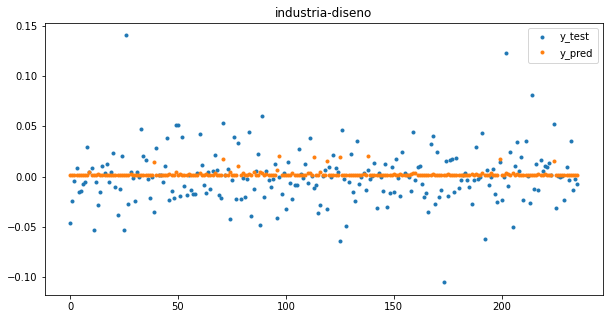

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


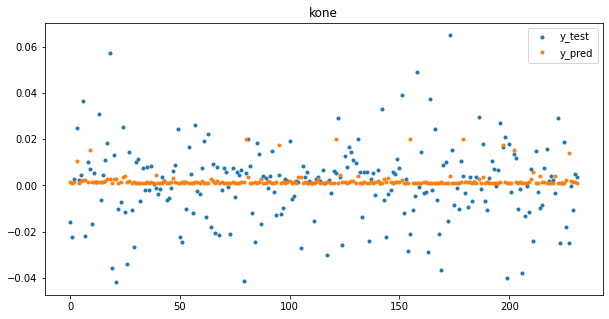

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


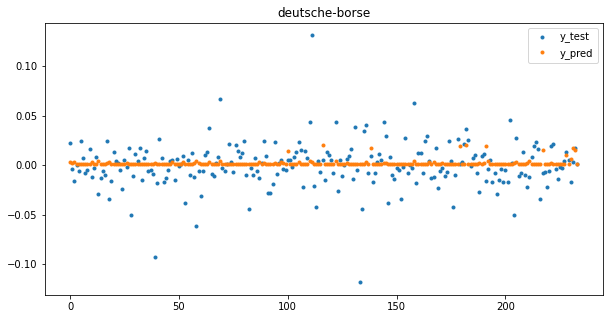

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


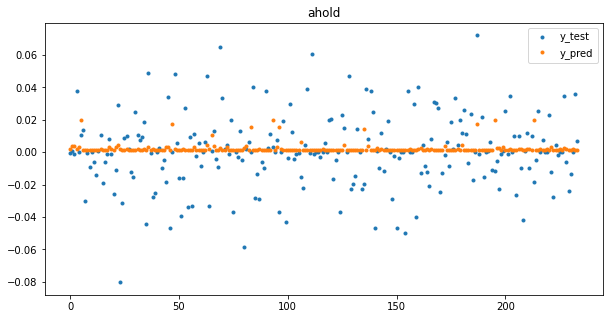

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


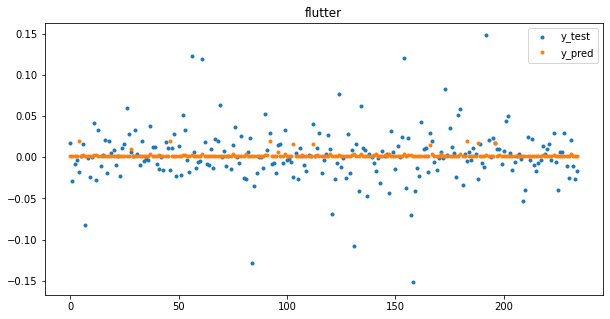

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


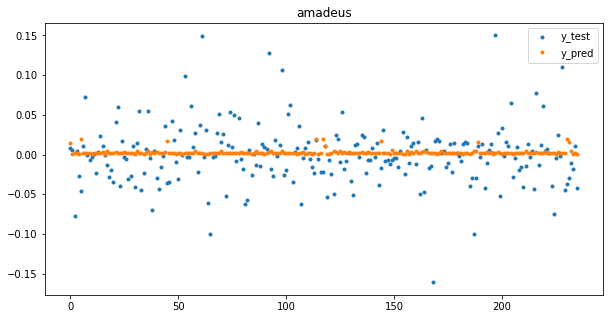

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


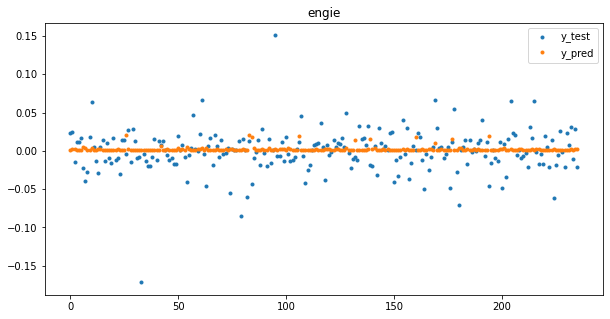

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


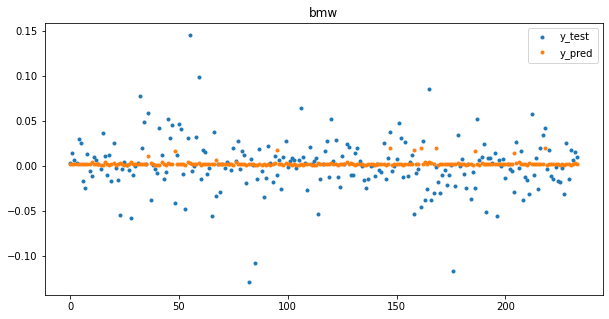

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


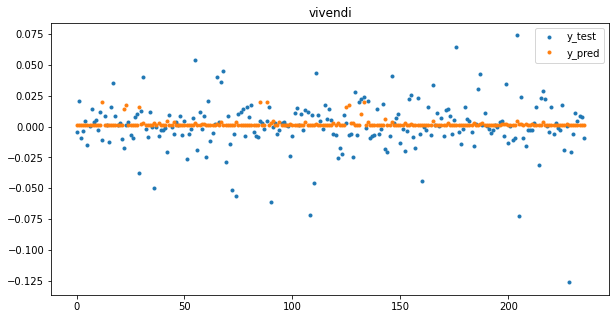

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


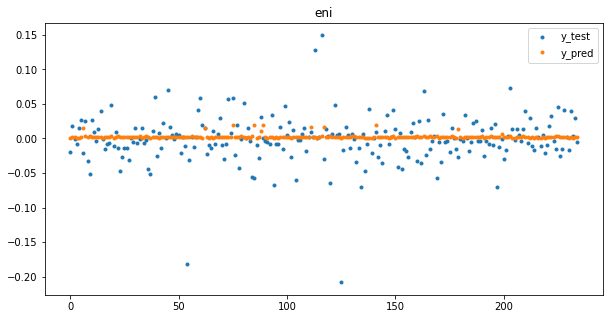

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


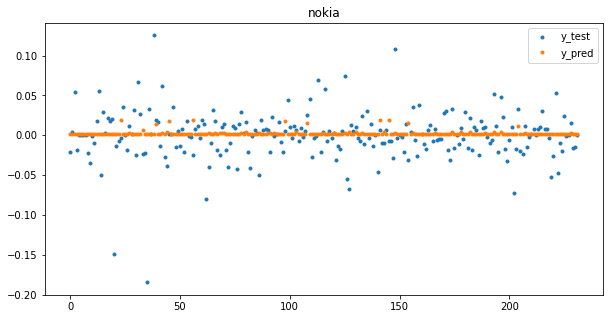

In [279]:
#---load the data with selected features

prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [281]:
prediction

{'asml': array([0.00136434, 0.00156587, 0.00389098, 0.00128229, 0.00121451,
        0.00155738, 0.00177993, 0.00127529, 0.00177993, 0.00118564,
        0.00307328, 0.00118564, 0.00284411, 0.00118564, 0.00126986,
        0.00118564, 0.00213675, 0.00423647, 0.00144127, 0.00123342,
        0.00118564, 0.0013778 , 0.00127455, 0.01344039, 0.00233866,
        0.00147067, 0.00118564, 0.00118564, 0.00177542, 0.00147117,
        0.00144444, 0.00135007, 0.00149384, 0.00171841, 0.00129263,
        0.00125764, 0.00118564, 0.0017426 , 0.00151918, 0.00151728,
        0.01505088, 0.00144053, 0.00152809, 0.00148748, 0.00166666,
        0.00310705, 0.00149386, 0.00123595, 0.00147117, 0.00190331,
        0.00129413, 0.00118564, 0.00178818, 0.00119827, 0.00118564,
        0.00155784, 0.00389098, 0.00137257, 0.0013778 , 0.00140849,
        0.00254802, 0.00118564, 0.00292552, 0.00160312, 0.00423647,
        0.00162027, 0.0012275 , 0.00118564, 0.0013033 , 0.00122197,
        0.00118564, 0.00383773, 0.016745

In [282]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 20, 16)            33        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 128)           4224      
_________________________________________________________________
dropout_36 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 64)             16448     
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 4, 64)            

In [284]:
model.save('saved_test')

INFO:tensorflow:Assets written to: saved_test/assets


# Train model on different period: Jan 2012 Juin 2016

**Check if Annual Volatility impacts model score**

In [17]:
def load_preproc_data(company='vinci'):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class 
    prep_class = Data_Prep(company, 252)



    #---(2) Load the first dataframe ready to use if no more modification
    df = prep_class.data_prep()



    #---(3) Function that allows us to delete some of the features we don't want to use for modelling 
    # Log Return is to False by default
    # *******************
    # if period < 252 , don't use Annual_vol
    #********************
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                            Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    #---(4) Function that add the exogenous features that you need to select 
    # returns the dataframe ready to modelling 
    # and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
    df = exo_selection(df, sp500=True, gold=True, eurusd=True, nasdaq=True, crude=True, vix=True)

    #---(5) Sort values to make sure they are ordered *in case and drop data column
    df = df.sort_values('Date')
#     df = df.drop(columns='Date')
    
    df = df.set_index('Date')
    
    #---Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [18]:
#---load the data with selected features
data = []
idx = []
for company in company_dict.keys():
    data_loc, idx_loc = load_preproc_data(company)
    data.append(data_loc[:int(data_loc.shape[0]*0.6)])  # Pre-covid data
    idx.append(idx_loc)

(16399, 20, 15)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 20, 15)            31        
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 128)           3968      
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 64)             16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 6

Epoch 49/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 50/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 51/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 52/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 53/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 54/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 55/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 56/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103


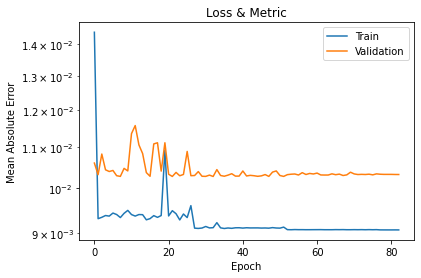

early stopping at 82 epoch.
val_mae: 0.01027256902307272


In [19]:
#---train the model
X_train, y_train, X_val, y_val, X_test, y_test, model = train_model(df=data,
                                                                    idx=idx,
                                                                    len_=20, 
                                                                    l_rate=0.01,
                                                                    batch_size=32,
                                                                    patience=50,
                                                                    loss='MAE',
                                                                    metric=MAE,
                                                                    plot_history=True, 
                                                                    verbose=2)

In [20]:
#baseline
np.mean(np.abs(y_test))

0.010177065090330745

In [22]:
#greater than the start date and smaller than the end date
def load_predict_data(company=None, start_date = '2020-01-03', end_date = '2020-12-31', len_=20):
    
    prep_class = Data_Prep_Api(company, 252)
    df = prep_class.data_prep_api() # (max=True)
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection_api(df, ["sp500","gold", "eurusd", "nasdaq", "crude", "vix"]) # ,max=True)

    df = df.sort_values('Date')
    
    start_date_delta = str((datetime.strptime('2020-01-03', '%Y-%m-%d') - timedelta(days=len_)).date())
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]
    
    df = df.set_index('Date')
    
    #Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


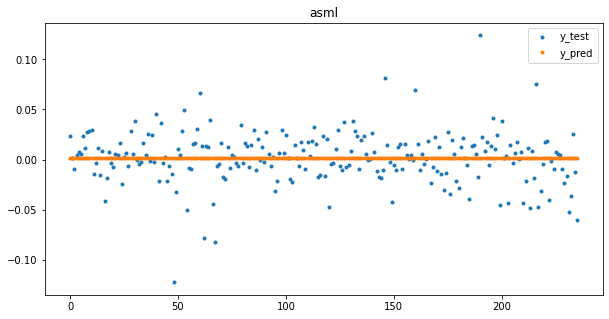

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


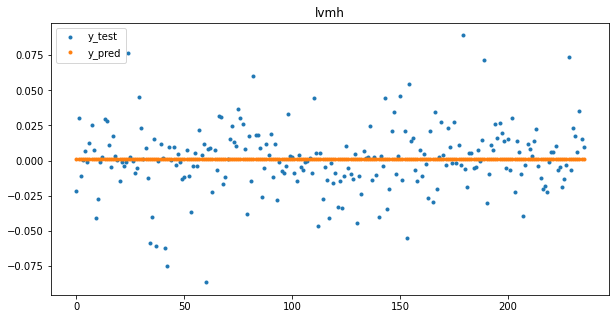

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


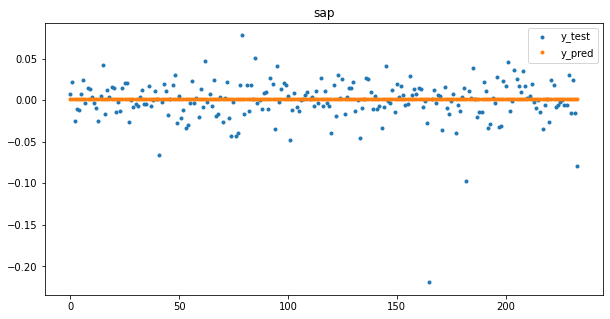

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 15)


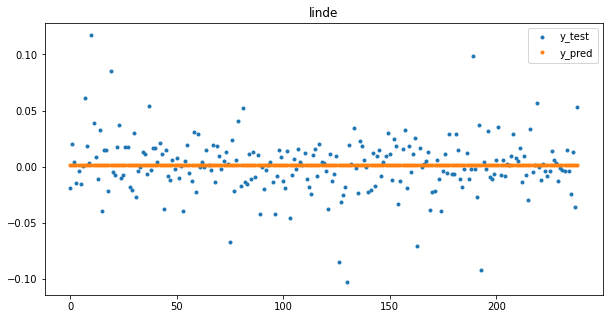

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


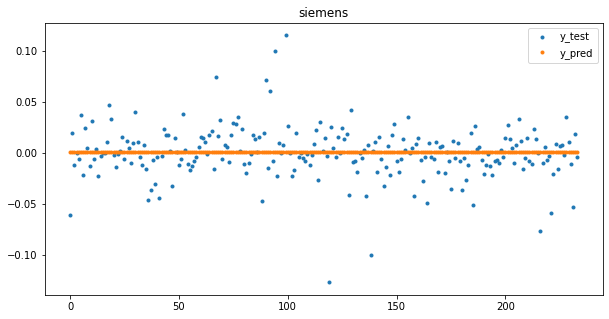

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


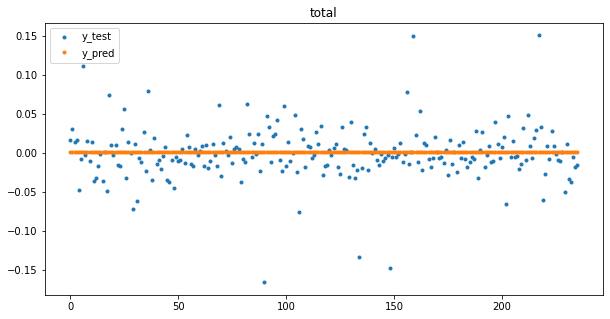

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


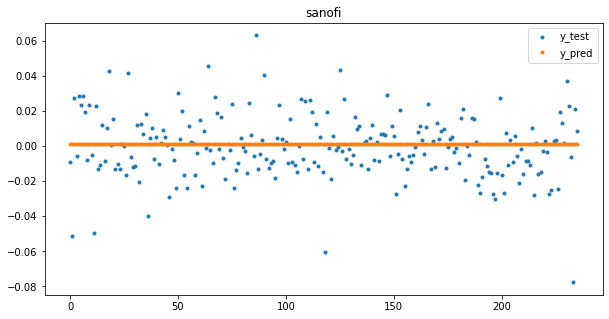

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


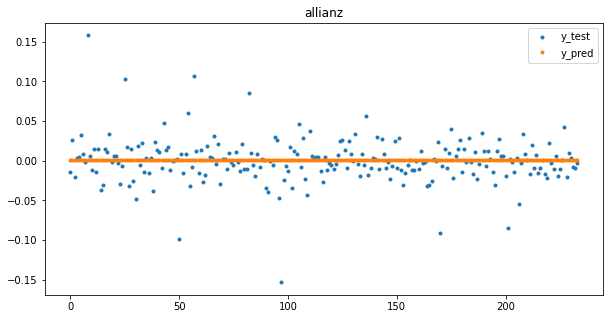

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


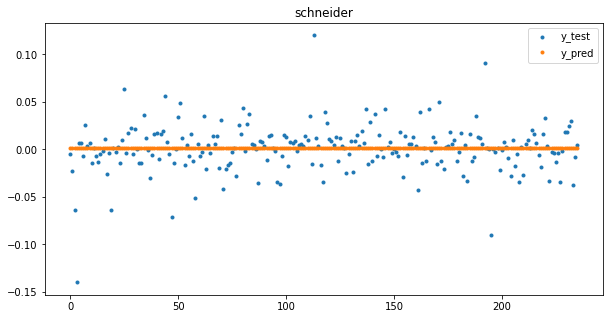

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


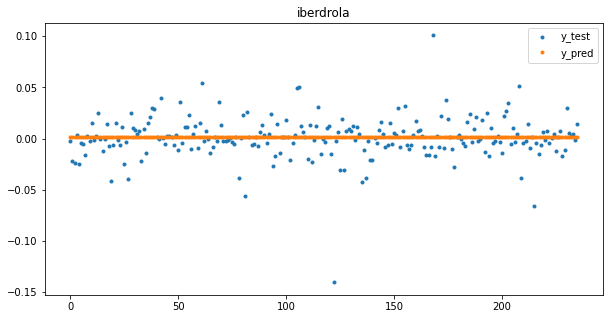

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


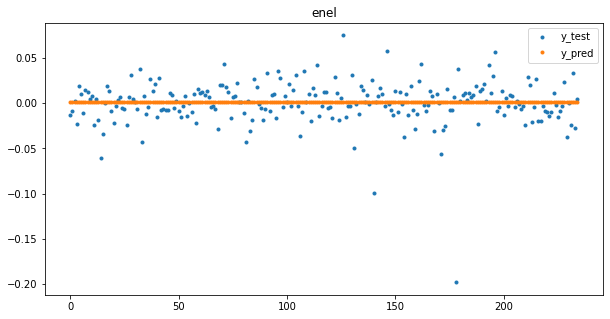

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


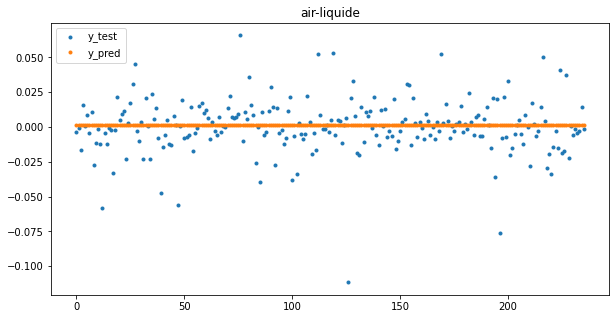

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


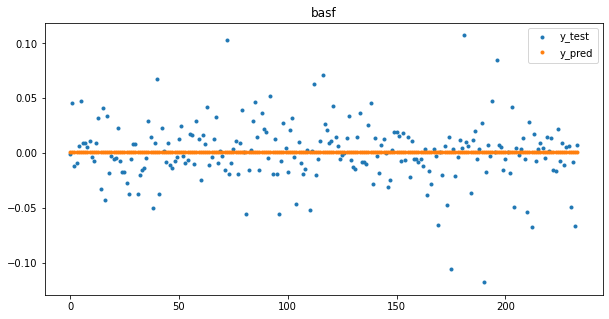

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


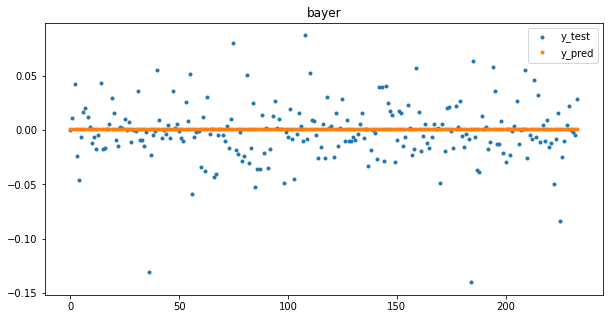

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


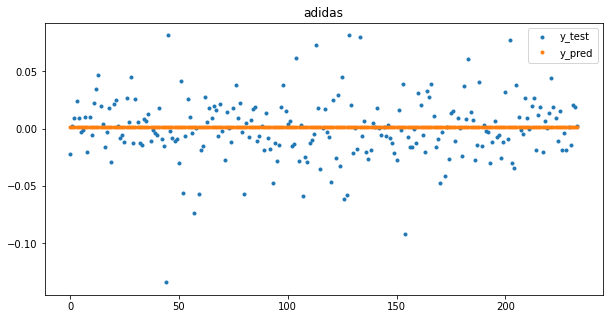

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


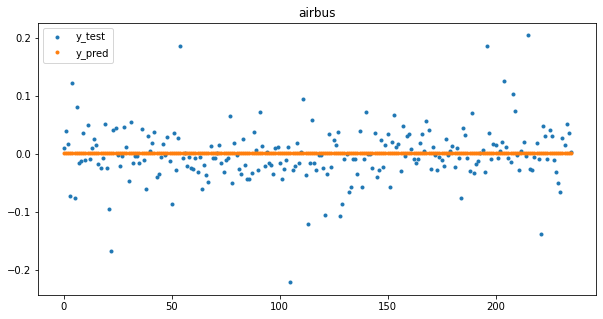

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


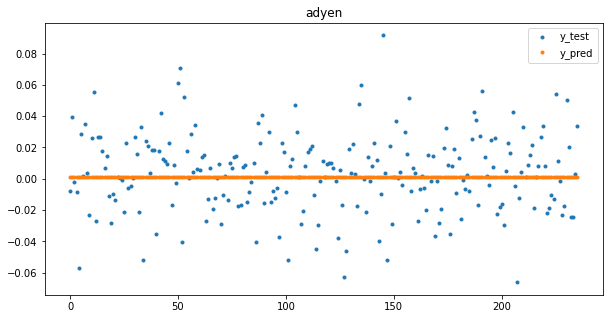

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


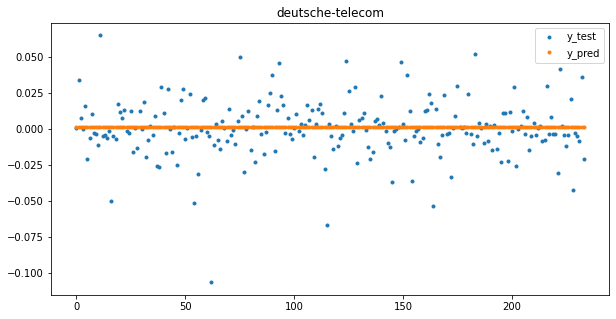

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


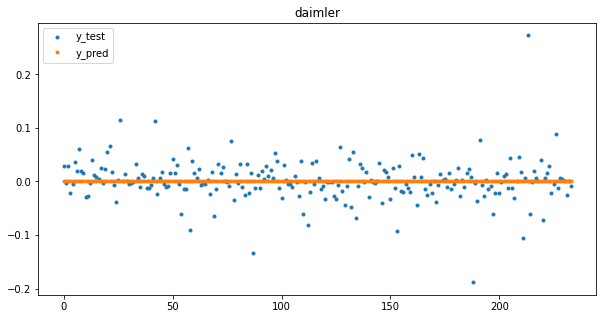

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


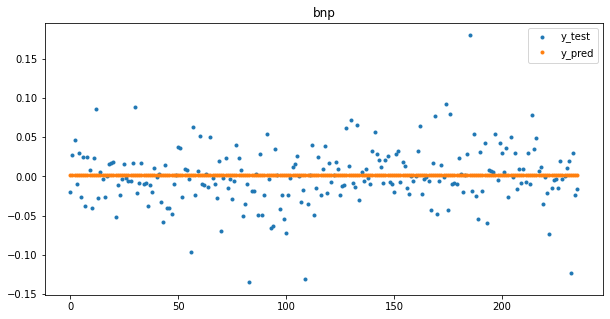

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


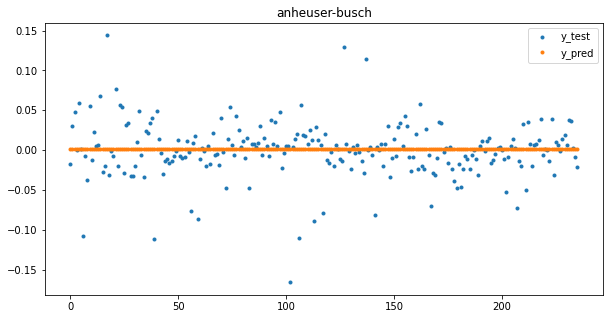

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


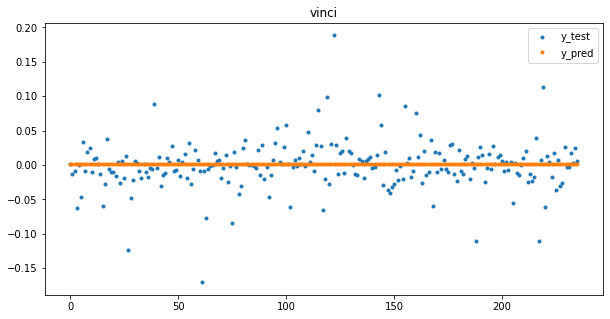

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


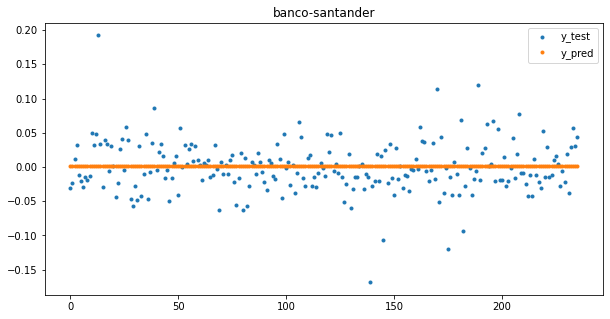

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


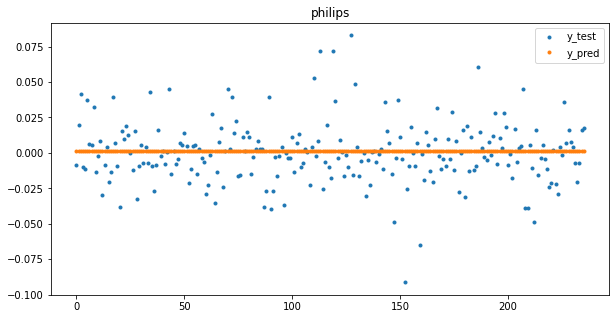

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


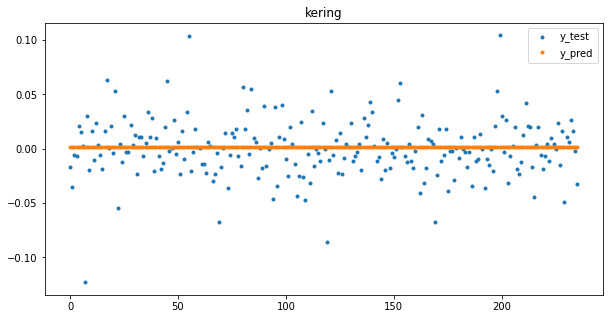

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


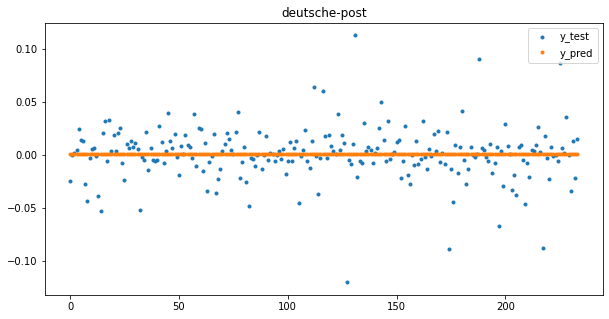

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


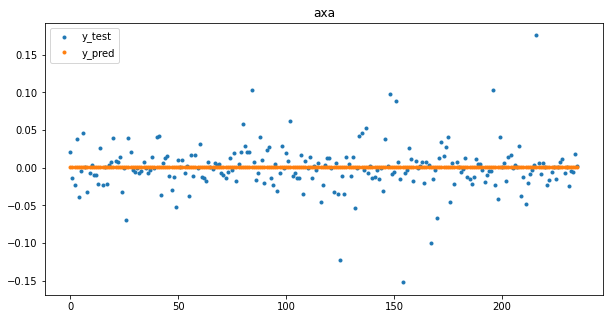

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


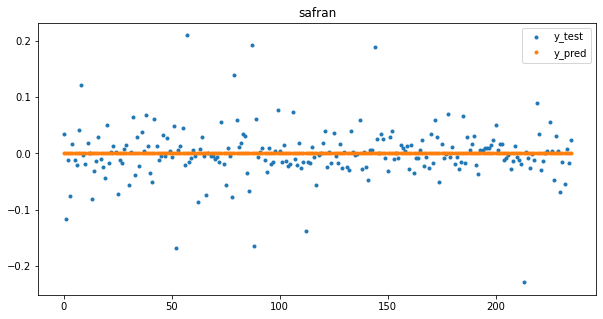

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


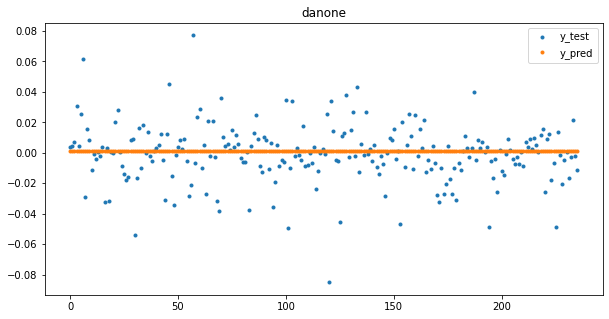

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


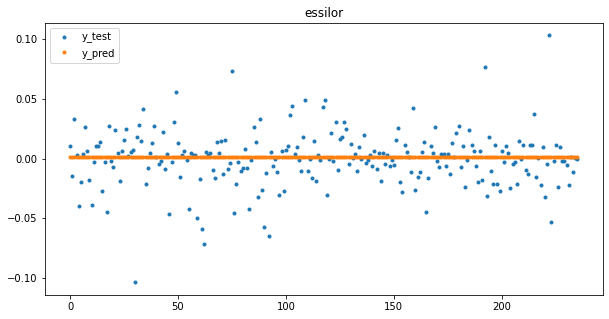

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


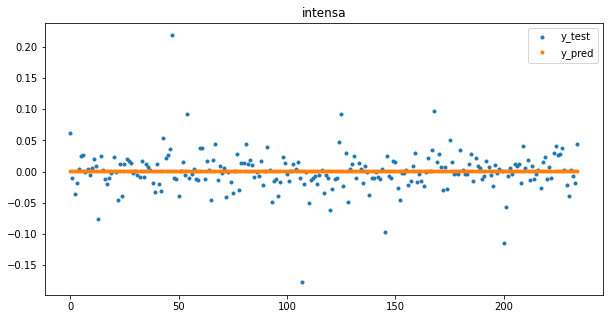

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


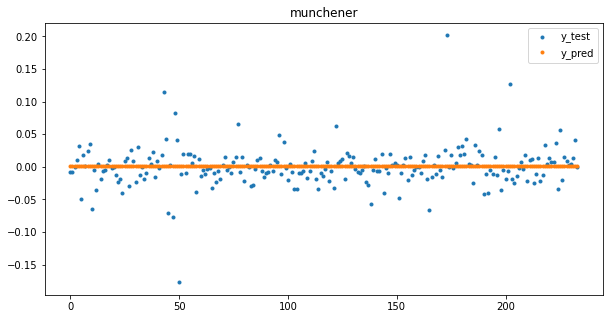

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


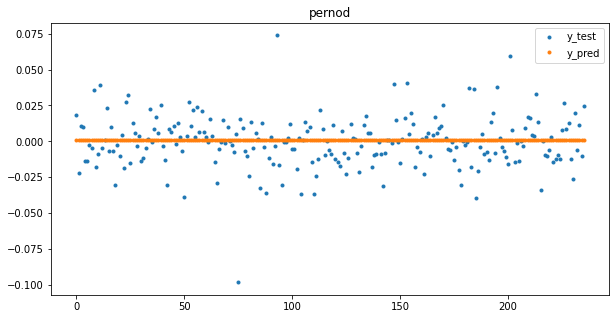

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


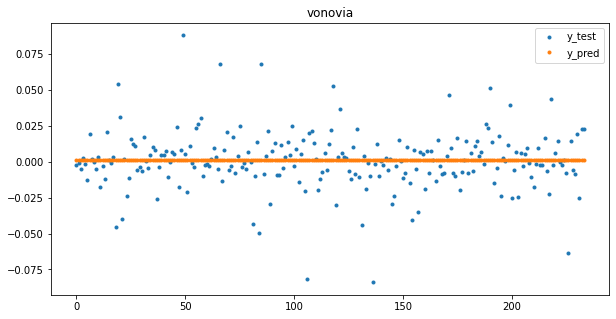

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


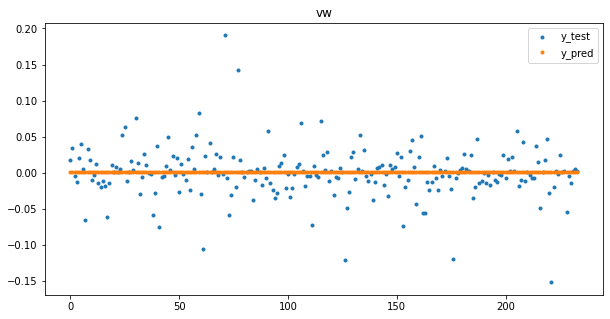

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


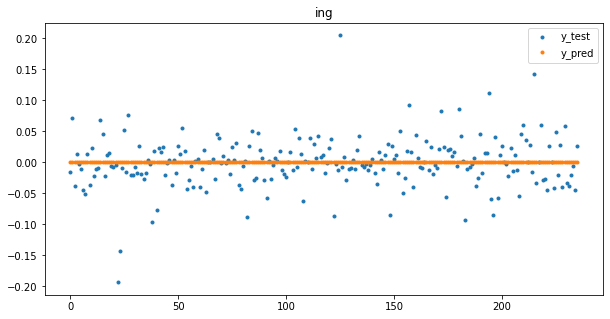

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


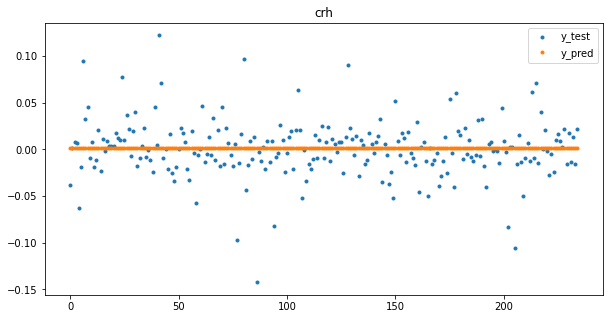

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


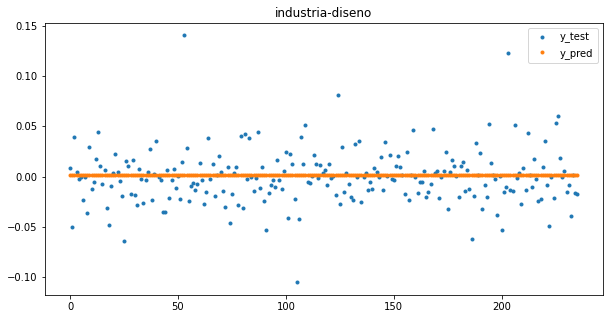

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 15)


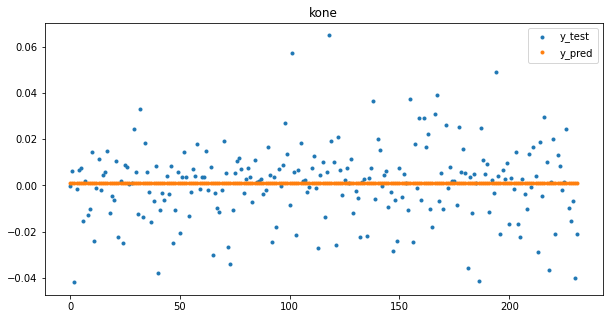

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


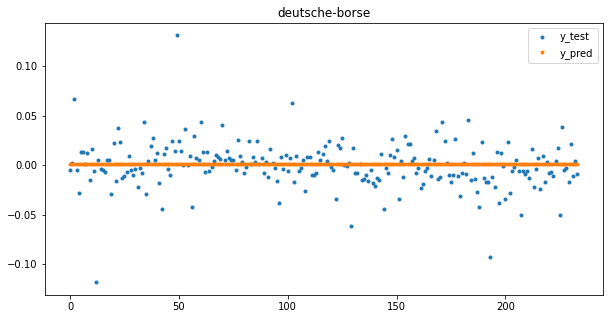

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


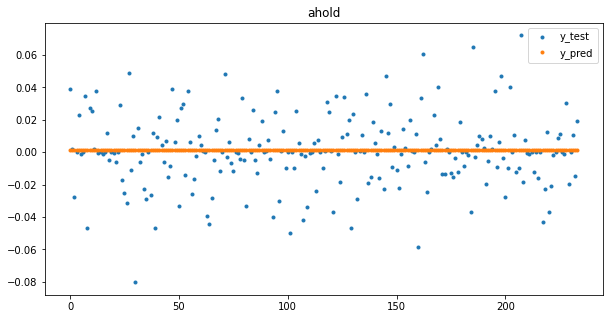

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


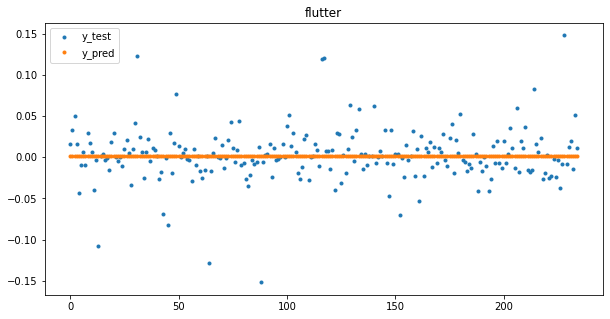

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


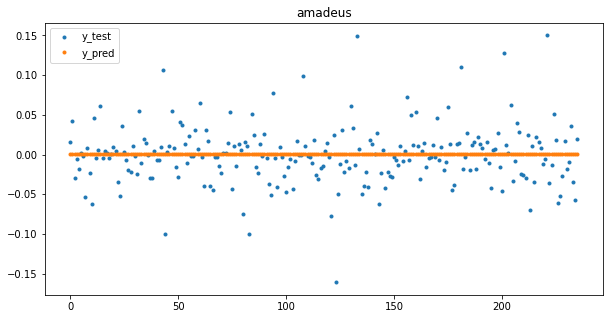

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


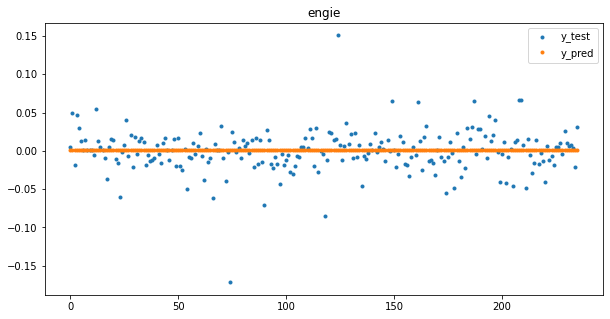

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


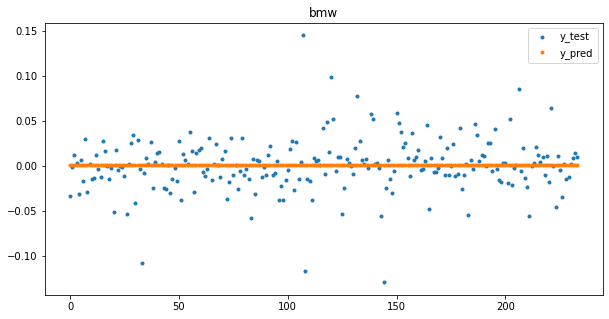

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


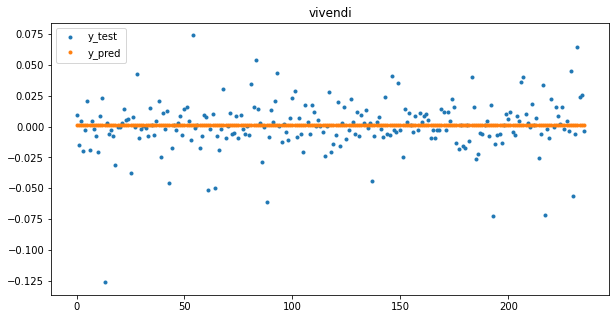

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


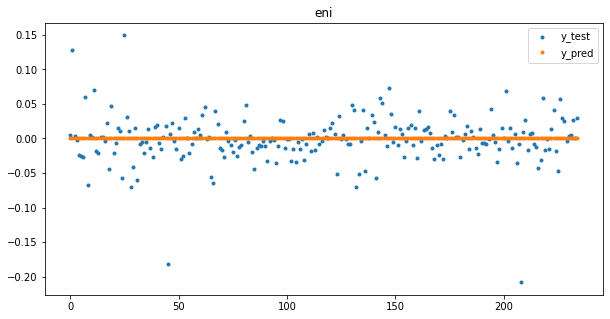

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 15)


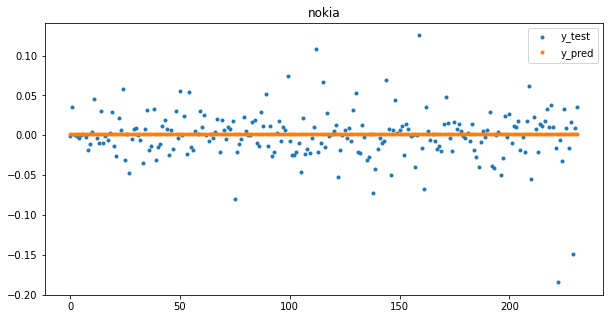

In [23]:
#---load the data with selected features

prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [26]:
model.save('saved_5y_cnn')

INFO:tensorflow:Assets written to: saved_5y_cnn/assets


In [29]:
X_test_loc.shape

(232, 20, 15)